# Notebook to plot all PS and ND so far

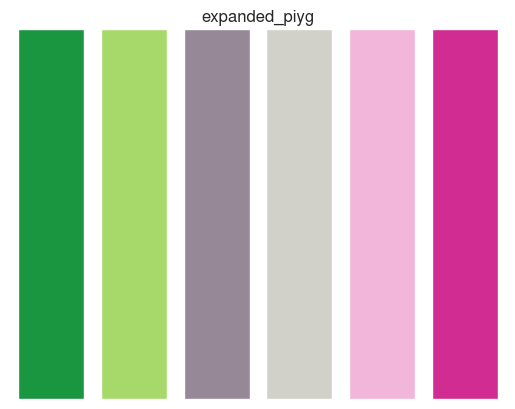

[(0, '#1a9641'),
 (1, '#a6d96a'),
 (2, '#978897'),
 (3, '#d1d1ca'),
 (4, '#f1b6da'),
 (5, '#d02c91')]

In [23]:
import napari
from macrohet import dataio, tile, tools, visualise, colours
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np
from macrohet.notify import send_sys_message as notify
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zarr
import csv
import re

palette = colours.expanded_piyg
sns.set_theme(style = 'white')
sns.set(font='Nimbus Sans', style = 'white')
fluo_scaling_factor = 1 #/1.55E10 # for plotting
meters_per_pixel = 1.4949402023919043E-07 # how many meters per pixel
# Define a function to remove outliers using IQR
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]
    
import warnings
import pandas as pd
# Disable the FutureWarning related to use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)
with pd.option_context('mode.use_inf_as_na', True):
    pass 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors
[(n, i) for n, i in enumerate(colours.expanded_piyg)]

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Get the PiYG colormap
cmap_piyg = plt.get_cmap('PiYG')
N=6#len(condition_indices)
# Define the indices for the pink colors in PiYG
start_index = 0  # Start of pink colors
end_index = 128-50    # End of pink colors (PiYG has 256 colors)
# Extract the pink colors from PiYG
pink_colors = cmap_piyg(range(start_index, end_index + 1))
# Create a custom pink colormap
# custom_pink_cmap = LinearSegmentedColormap.from_list('CustomPink', pink_colors,  N=len(condition_indices))
# Calculate indices for evenly spaced colors
pink_indices = np.linspace(0, len(pink_colors) - 1, N, dtype=int)
custom_pink_cmap = pink_colors[pink_indices]

# Define the indices for the pink colors in PiYG
start_index = 128+50# Start of pink colors
end_index = 255    # End of pink colors (PiYG has 256 colors)

# Extract the pink colors from PiYG
green_colors = cmap_piyg(range(start_index, end_index + 1))
green_colors = np.flip(green_colors, axis = 0)
# Create a custom pink colormap
# custom_green_cmap = LinearSegmentedColormap.from_list('CustomGreen', green_colors, N=len(condition_indices))
green_indices = np.linspace(0, len(green_colors) - 1, N, dtype=int)
custom_green_cmap = green_colors[green_indices]

# Set directory addresses

In [5]:
base_dir = f'/mnt/SYNO/macrohet_syno/'
output_dir = '/mnt/SYNO/macrohet_syno/manuscript/results'

# Load previous DFs and associated assay_layouts

# !!! CHANGE THIS TO AREA MEASUREMENTS ONCE COMPLETE

In [46]:
rfp_raw_data_fns = glob.glob(os.path.join(base_dir, '*/results/whole_fov_mtb_growth/raw_data/RFP_signals.csv'))
rfp_raw_data_fns

['/mnt/SYNO/macrohet_syno/ND0002/results/whole_fov_mtb_growth/raw_data/RFP_signals.csv',
 '/mnt/SYNO/macrohet_syno/PS0000/results/whole_fov_mtb_growth/raw_data/RFP_signals.csv']

In [4]:
# Regular expression pattern to match the expt_ID
pattern = r'/macrohet_syno/([A-Z0-9]+)'
# Initialize a list to store the extracted expt_IDs
expt_IDs = ['PS0000', 'ND0002', 'ND0003'] #[re.search(pattern, fn).group(1) for fn in rfp_raw_data_fns]
assay_layouts = {}
for expt_ID in expt_IDs:
    metadata_path = glob.glob(os.path.join(base_dir, f'{expt_ID}/acquisition/Assaylayout/*.xml'))[0]
    assay_layouts[expt_ID] = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)

Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


### RFP raw signal stuff

In [651]:
n_data = pd.read_csv(rfp_raw_data_fns[0])
del n_data['Row']
n_data.rename_axis('Time', inplace=True)
n_data = n_data.iloc[1:]
n_data.columns = assay_layouts['ND0002'].index
# scale time axis properly 
n_data['Time (hours)'] = np.arange(n_data.index.min()-0.5, n_data.index.max()/2+0.5, 0.5 )
n_data.set_index('Time (hours)', inplace=True)

In [652]:
p_data = pd.read_csv(rfp_raw_data_fns[1])
del p_data['Row']
p_data.rename_axis('Time', inplace=True)
p_data = p_data.iloc[1:]
p_data.columns = assay_layouts['PS0000'].index
# p_data = p_data.T
p_data.rename_axis('Time (hours)', inplace=True)

In [653]:
dfs = {}
dfs['PS0000'] = p_data
dfs['ND0002'] = n_data

# Set one condition to plot

In [60]:
condition_indices = {}
for expt_ID in expt_IDs:
    assay_layout = assay_layouts[expt_ID]
    condition_indices[expt_ID] = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == 'WT')].index

In [659]:
condition_indices

{'ND0002': MultiIndex([(3, 3),
             (3, 4),
             (4, 3),
             (4, 4)],
            names=['Row', 'Column']),
 'PS0000': MultiIndex([(3, 5),
             (4, 5),
             (5, 5),
             (6, 5)],
            names=['Row', 'Column'])}

# Plot

### jUST WILD-TYPE

In [523]:
#total area of fov in metres
(6048*6048)*(meters_per_pixel**2)

8.17468840160837e-07

In [525]:
#total area of fov in millimetres
(6048*6048)*((meters_per_pixel*1E3)**2)

0.8174688401608371

In [16]:
((meters_per_pixel*1E3)**2)

2.234846208727548e-08

In [80]:
image_resolution=1.4949402023919043e-07

# Convert the resolution to pixels per micrometer
resolution_micrometers_per_pixel = image_resolution * 1_000_000

# Convert area from pixels to micrometers squared
print (resolution_micrometers_per_pixel ** 2)


0.022348462087275475


In [527]:
#total area of fov in microns
(6048*6048)*((meters_per_pixel*1E6)**2)

817468.8401608368

In [514]:
cleaned_series

Time (hours)
1      474505398
2      491920985
3      505544427
4      503978580
5      514928508
         ...    
71    3124353794
72    3167643496
73    3257858746
74    3289297479
75    3437894318
Name: (6, 5), Length: 75, dtype: int64

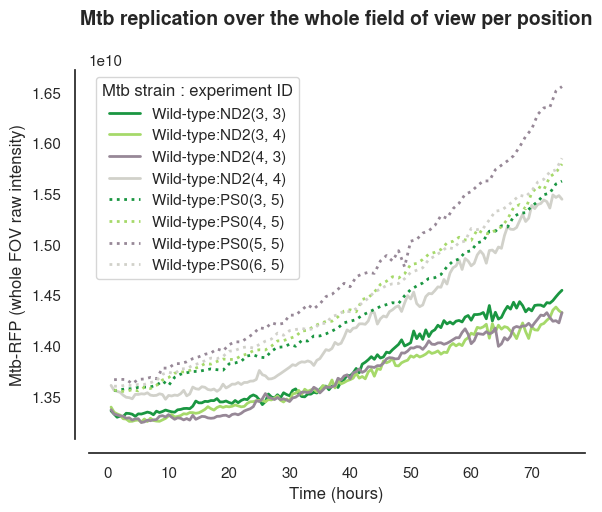

In [661]:
for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
    assay_layout = assay_layouts[expt_ID]
    rfp_df = dfs[expt_ID]
    condition = 'WT'
    condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == 'WT')].index
    # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
    for i, (index, colour) in enumerate(zip(condition_indices, colours.expanded_piyg)):
        expt_ID = expt_ID.replace('000','')
        condition_label = 'Wild-type'#formatting_dict[condition] if condition in formatting_dict.keys() else 'RD1', 
        cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])

        sns.lineplot(
            data=cleaned_series * fluo_scaling_factor,
            
            label=f'{condition_label}:{expt_ID}{index}',
            linewidth=2,
            color = colour, 
            linestyle=linestyle,
        )
# # Update x-axis labels to represent 30-minute intervals
# x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
# x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
# plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
# sns.set_palette = colours.expanded_piyg
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view per position', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'FOV_wild_type_Mtb_per_position_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

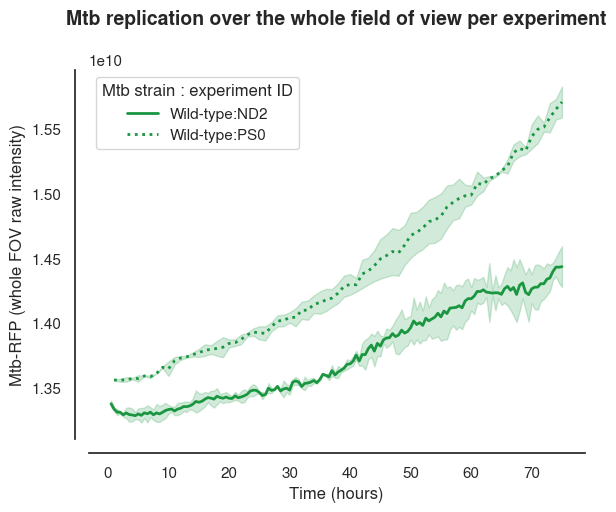

In [662]:
for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
    assay_layout = assay_layouts[expt_ID]
    rfp_df = dfs[expt_ID]
    condition = 'WT'
    expt_ID = expt_ID.replace('000','')
    condition_label = 'Wild-type'#formatting_dict[condition] if condition in formatting_dict.keys() else 'RD1', 
    condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == 'WT')].index
    # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
    cleaned_concat_series = []
    for i, (index, colour) in enumerate(zip(condition_indices, colours.expanded_piyg[0:2])):
        cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
        cleaned_concat_series.append(cleaned_series)
    concat_series = pd.concat(cleaned_concat_series)
    sns.lineplot(
        data=concat_series * fluo_scaling_factor,
        
        label=f'{condition_label}:{expt_ID}',
        linewidth=2,
        color = colours.expanded_piyg[0], 
        linestyle=linestyle,
        ci = 'sd'
    )
# # Update x-axis labels to represent 30-minute intervals
# x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
# x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
# plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
# sns.set_palette = colours.expanded_piyg
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view per experiment', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'FOV_wild_type_combined_per_expt_Mtb_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

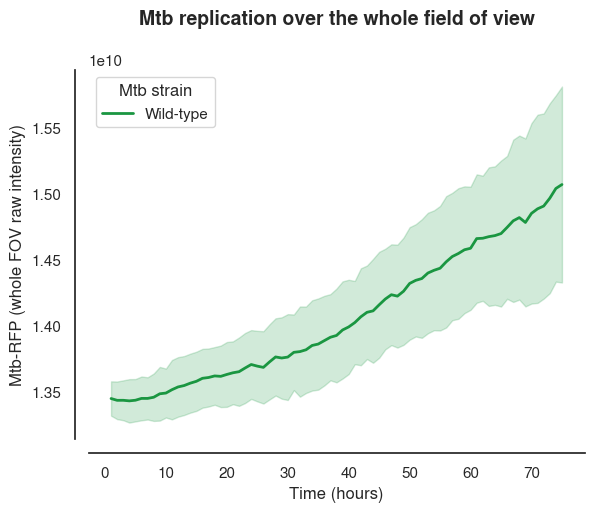

In [663]:
cleaned_concat_series = []
for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
    assay_layout = assay_layouts[expt_ID]
    rfp_df = dfs[expt_ID]
    condition = 'WT'
    expt_ID = expt_ID.replace('000','')
    condition_label = 'Wild-type'#formatting_dict[condition] if condition in formatting_dict.keys() else 'RD1', 
    condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == 'WT')].index
    # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
    
    for i, (index, colour) in enumerate(zip(condition_indices, colours.expanded_piyg[0:2])):
        cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
        cleaned_concat_series.append(cleaned_series)
concat_series = pd.concat(cleaned_concat_series, axis = 0)
concat_series = concat_series[concat_series.index % 1 == 0]
sns.lineplot(
    data=concat_series * fluo_scaling_factor,
    
    label=f'{condition_label}',
    linewidth=2,
    color = colours.expanded_piyg[0], 
    linestyle='-',
    ci = 'sd'
)
# # Update x-axis labels to represent 30-minute intervals
# x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
# x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
# plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
# sns.set_palette = colours.expanded_piyg
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'Mtb strain')  # Add a legend
plt.savefig(os.path.join(output_dir, 'FOV_wild_type_combined_Mtb_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

### RD1 and WT

In [58]:
formatting_dict = {}
formatting_dict['WT'] = 'Wild-type'
formatting_dict['RD1'] = 'ΔRD1'

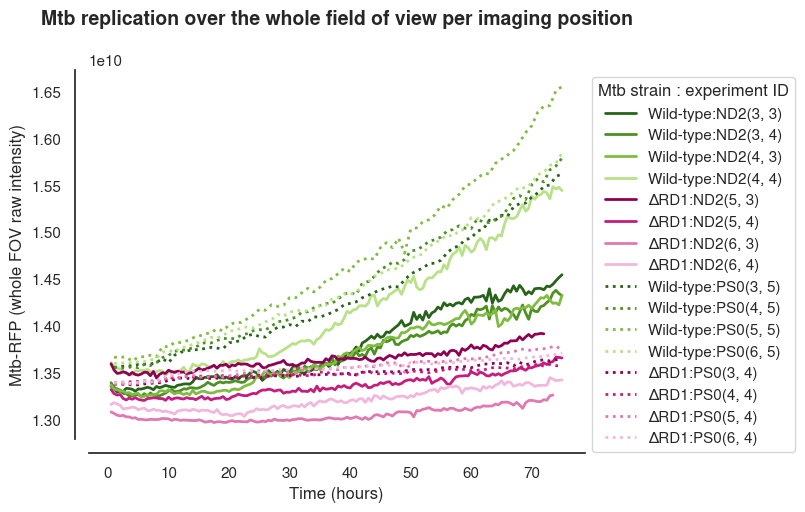

In [664]:
for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
    assay_layout = assay_layouts[expt_ID]
    rfp_df = dfs[expt_ID]
    for condition, colour_map in zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap]):
        # condition = 'WT'
        condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == condition)].index
        # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
        for i, (index, colour) in enumerate(zip(condition_indices, sns.palettes.color_palette(colour_map, n_colors=len(condition_indices)))):
            expt_ID = expt_ID.replace('000','')
            condition_label = str(formatting_dict[condition])
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            # sns.set_palette(colour_map)
            sns.lineplot(
                data=cleaned_series * fluo_scaling_factor,
                
                label=f'{condition_label}:{expt_ID}{index}',
                linewidth=2,
                color = colour, 
                linestyle=linestyle,
                # alpha = 0.5 if condition == 'RD1' else 1,
                # cmap = colour_map
            )
# # Update x-axis labels to represent 30-minute intervals
# x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
# x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
# plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
# sns.set_palette = colours.expanded_piyg
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view per imaging position', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'FOV_wild_type_RD1_Mtb_per_position_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

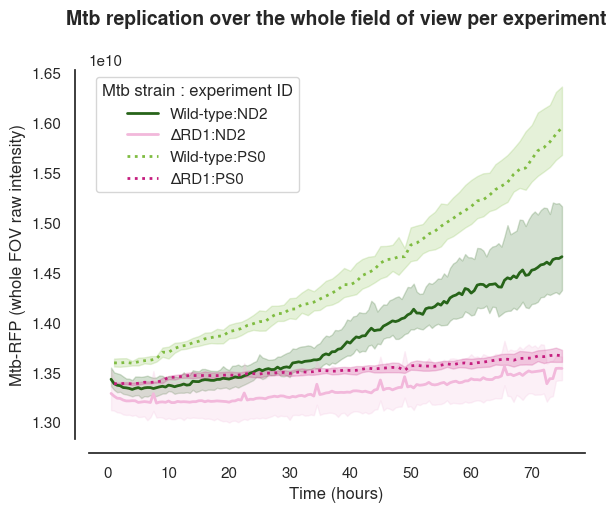

In [665]:
colour_i = 0
for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
    assay_layout = assay_layouts[expt_ID]
    rfp_df = dfs[expt_ID]
    expt_ID = expt_ID.replace('000','')
    for condition, colour_map in zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap]):
        # condition = 'WT'
        condition_label = str(formatting_dict[condition])
        condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == condition)].index
        # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
        cleaned_concat_series = []
        
        for i, index, in enumerate(condition_indices):#, sns.palettes.color_palette(colour_map, n_colors=len(condition_indices)))):
            
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            cleaned_concat_series.append(cleaned_series)
        concat_series = pd.concat(cleaned_concat_series)
        colour = sns.palettes.color_palette(colour_map, n_colors=4)[-colour_i] # minus i to reverse the ordering of the colours for ease of viewing
        # print(condition_label,expt_ID,index)
        sns.lineplot(
            data=concat_series * fluo_scaling_factor,
                # sns.set_palette(colour_map)
                label=f'{condition_label}:{expt_ID}',
                linewidth=2,
                color = colour, 
                linestyle=linestyle,
                # alpha = 0.5 if condition == 'RD1' else 1,
                # cmap = colour_map
            alpha =1
            )
        colour_i+=1
# # Update x-axis labels to represent 30-minute intervals
# x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
# x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
# plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
# sns.set_palette = colours.expanded_piyg
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view per experiment', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'FOV_wild_type_RD1_combined_per_expt_Mtb_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

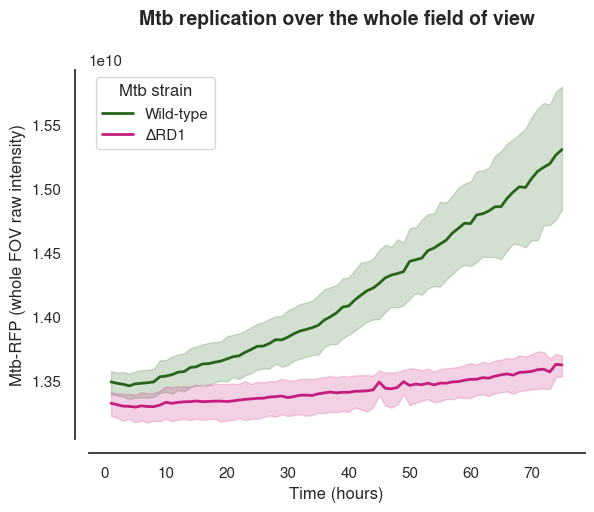

In [666]:
colour_i = 0
for condition, colour_map in zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap]):
    # condition = 'WT'
    condition_label = str(formatting_dict[condition])
    
    # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
    cleaned_concat_series = []
    for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
        assay_layout = assay_layouts[expt_ID]
        condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == condition)].index
        
        rfp_df = dfs[expt_ID]
        expt_ID = expt_ID.replace('000','')
    
        
        for i, index, in enumerate(condition_indices):#, sns.palettes.color_palette(colour_map, n_colors=len(condition_indices)))):
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            cleaned_concat_series.append(cleaned_series)
    concat_series = pd.concat(cleaned_concat_series)
    concat_series = concat_series[concat_series.index % 1 == 0]
    colour = sns.palettes.color_palette(colour_map, n_colors=4)[colour_i]
    # print(condition_label,expt_ID,index)
    sns.lineplot(
        data=concat_series * fluo_scaling_factor,
            # sns.set_palette(colour_map)
            label=f'{condition_label}',
            linewidth=2,
            color = colour, 
            linestyle='-',
            # alpha = 0.5 if condition == 'RD1' else 1,
            # cmap = colour_map
        alpha =1
        )
    colour_i+=1
# # Update x-axis labels to represent 30-minute intervals
# x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
# x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
# plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
# sns.set_palette = colours.expanded_piyg
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Mtb-RFP (whole FOV raw intensity)')
plt.title('Mtb replication over the whole field of view', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'Mtb strain')  # Add a legend
plt.savefig(os.path.join(output_dir, 'FOV_wild_type_RD1_combined_Mtb_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

# Comparing bulk analysis to single-cell 

Right now I only have long tracks >70 hours and from PS000 data set as ND2 still segmenting

In [253]:
PS_sc_df_fn = '/mnt/SYNO/macrohet_syno/PS0000/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_area_false_outliers_removed.pkl'
ND_sc_df_fn = '/mnt/SYNO/macrohet_syno/ND0002/results/unchecked_74_corrected_area_df.pkl'

In [293]:
ND_sc_df['Acquisition ID'].unique()

array([(3, 4), (4, 3), (4, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9),
       (3, 10), (3, 11), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9),
       (4, 10), (3, 3)], dtype=object)

In [257]:
for glob.glob('../viewer/*different_area_measure_approach*')

['../viewer/5reversed_different_area_measure_approach.pkl',
 '../viewer/reversed_different_area_measure_approach (copy).pkl',
 '../viewer/different_area_measure_approach.pkl',
 '../viewer/reversed_different_area_measure_approach.pkl',
 '../viewer/4reversed_different_area_measure_approach.pkl',
 '../viewer/6reversed_different_area_measure_approach.pkl']

In [258]:
r3_df = pd.read_pickle('../viewer/different_area_measure_approach.pkl')
r4_df = pd.read_pickle('../viewer/4reversed_different_area_measure_approach.pkl')
r5_df = pd.read_pickle('../viewer/5reversed_different_area_measure_approach.pkl')
r6_df = pd.read_pickle('../viewer/6reversed_different_area_measure_approach.pkl')

In [262]:
r3_df['Acquisition ID'][0]

(3, 5)

In [264]:
r3_df = r3_df[r3_df['Acquisition ID'].apply(lambda x: x[0] == 3)]
r4_df = r4_df[r4_df['Acquisition ID'].apply(lambda x: x[0] == 4)]
r5_df = r5_df[r5_df['Acquisition ID'].apply(lambda x: x[0] == 5)]
r6_df = r6_df[r6_df['Acquisition ID'].apply(lambda x: x[0] == 6)]

In [271]:
df = pd.concat([r3_df, r4_df, r5_df, r6_df], axis=0, ignore_index=True)

In [275]:
df[df['Mtb Area'] != df['Mtb area new (um2)']]

Time (hours)   Mtb Area       dMtb Strain Compound Concentration  \
962                6   5.363631   2.994694     WT      PZA          EC50   
4653              47  29.142395   5.050752     WT      RIF          EC50   
4654              48  32.896936   5.050752     WT      RIF          EC50   
4831               0  20.982339  55.362258     WT      INH          EC50   
4832               1  22.905540  55.362258     WT      INH          EC50   
...              ...        ...        ...    ...      ...           ...   
288097            73  60.591636  48.425769     WT      INH          EC99   
288098            74  56.896497  48.425769     WT      INH          EC99   
288522            58   0.000000   0.804545     WT      PZA          EC99   
289499            12   1.474998   1.050378     WT      INH          EC99   
289835            58   0.000000   1.005681     WT      PZA          EC99   

       Unique ID Acquisition ID  Cell ID     Mphi Area  ...    %dMtb/dt  \
962     1049.3.6         (3, 6)     1049  14814.000000  ...  150.000000   
4653     137.3.7         (3, 7)      137  19048.500000  ...  873.134328   
4654     137.3.7         (3, 7)      137  19304.666667  ...   12.883436   
4831      14.3.8         (3, 8)       14  20822.000000  ...    0.000000   
4832      14.3.8         (3, 8)       14  22526.000000  ...    9.165808   
...          ...            ...      ...           ...  ...         ...   
288097   840.6.8         (6, 8)      840  32667.000000  ...  -11.181501   
288098   840.6.8         (6, 8)      840  31769.000000  ...   -6.098431   
288522   853.6.6         (6, 6)      853  31279.666667  ... -100.000000   
289499   881.6.8         (6, 8)      881  19971.000000  ...   29.411765   
289835   897.6.6         (6, 6)      897  17866.666667  ...    0.000000   

             %dMtb  Mean Mtb Intensity  Thresholded Mean Mtb Intensity  \
962       0.000000          388.752706                        6.328600   
4653      0.000000          391.475952                       27.692875   
4654      0.000000          392.573242                       28.286579   
4831    263.851699          416.685059                       98.358177   
4832    263.851699          414.672699                       94.106010   
...            ...                 ...                             ...   
288097  571.683673          573.950684                      256.733521   
288098  571.683673          577.581421                      257.142731   
288522   64.285714          384.134013                       14.629948   
289499   88.679245          385.101517                        6.957674   
289835   37.815126          405.451843                       26.529798   

        Infection Status  Initial Infection Status Final Infection Status  \
962                 True                      True                   True   
4653                True                      True                   True   
4654                True                      True                   True   
4831                True                      True                   True   
4832                True                      True                   True   
...                  ...                       ...                    ...   
288097              True                      True                   True   
288098              True                      True                   True   
288522              True                     False                   True   
289499              True                     False                   True   
289835              True                      True                   True   

        dMtb/dt,T=15  Max. dMtb/dt,T=15  Mtb area new (um2)  
962              NaN           0.353106            0.000000  
4653        1.942826           1.942826            0.000000  
4654        1.883230           1.942826            5.162495  
4831             NaN           1.862696           21.700357  
4832             NaN           1.862696           23.689370  
...     

In [254]:
PS_sc_df = df = pd.read_pickle(PS_sc_df_fn)
ND_sc_df = df = pd.read_pickle(ND_sc_df_fn)

In [107]:
PS_sc_df[(PS_sc_df['Acquisition ID'] == (3, 5))
       & (PS_sc_df['Time (hours)'] == 0)
& (PS_sc_df['Mtb Area'] > 0)]

Time (hours)   Mtb Area        dMtb Strain Compound Concentration  \
0                  0  46.797680  136.772588     WT     CTRL           EC0   
7420               0   2.368937  456.601429     WT     CTRL           EC0   
11054              0  11.710594   41.590488     WT     CTRL           EC0   
12175              0  18.571572   34.260192     WT     CTRL           EC0   
12700              0   1.653786   42.372684     WT     CTRL           EC0   
...              ...        ...         ...    ...      ...           ...   
229981             0  15.733317   18.571572     WT     CTRL           EC0   
232000             0  23.778764   -4.313253     WT     CTRL           EC0   
234612             0   4.514389    5.721206     WT     CTRL           EC0   
270462             0   6.346963   -6.346963     WT     CTRL           EC0   
290998             0   9.453399   -9.453399     WT     CTRL           EC0   

       Unique ID Acquisition ID  Cell ID  Mphi Area  ...  dMtb/dt  %dMtb/dt  \
0          1.3.5         (3, 5)        1    29567.0  ...      0.0       0.0   
7420     109.3.5         (3, 5)      109   208842.0  ...      0.0       0.0   
11054    115.3.5         (3, 5)      115    70777.0  ...      0.0       0.0   
12175    117.3.5         (3, 5)      117   111516.0  ...      0.0       0.0   
12700    118.3.5         (3, 5)      118    17898.0  ...      0.0       0.0   
...          ...            ...      ...        ...  ...      ...       ...   
229981   610.3.5         (3, 5)      610    27762.0  ...      0.0       0.0   
232000   617.3.5         (3, 5)      617    48484.0  ...      0.0       0.0   
234612   624.3.5         (3, 5)      624    87927.0  ...      0.0       0.0   
270462    77.3.5         (3, 5)       77    19251.0  ...      0.0       0.0   
290998    93.3.5         (3, 5)       93    41849.0  ...      0.0       0.0   

               %dMtb  Mean Mtb Intensity  Thresholded Mean Mtb Intensity  \
0         292.263610          473.168976                      167.325424   
7420    19274.528302          352.281372                        1.064044   
11054     355.152672          370.706543                       16.412521   
12175     184.476534          378.559265                       19.426790   
12700    2562.162162          379.079956                       13.409375   
...              ...                 ...                             ...   
229981    118.039773          391.676788                       51.016857   
232000    -18.139098          385.320190                       47.147842   
234612    126.732673          374.833557                        5.133634   
270462   -100.000000          405.699646                       35.215988   
290998   -100.000000          385.519470                       25.851776   

        Infection Status Initial Infection Status  Final Infection Status  \
0                   True                     True                    True   
7420                True                     True                    True   
11054               True                     True                    True   
12175               True                     True                    True   
12700               True                     True                    True   
...                  ...                      ...                     ...   
229981              True                     True                    True   
232000              True                     True                    True   
234612              True                     True                    True   
270462              True                     True                   False   
290998              True                     True                    True   

        dMtb/dt,T=15  Max. dMtb/dt,T=15  
0                NaN           6.314185  
7420             NaN          25.107752  
11054            NaN           1.638887  
12175            NaN           1.320049  
12700            NaN           3.979516  
...              ...                ...  
22

In [55]:
for acq_ID in ND_sc_df['Acquisition ID'].unique():
    print(assay_layouts['ND0002'].loc[acq_ID]['Strain'], assay_layouts['ND0002'].loc[acq_ID]['Compound'], assay_layouts['ND0002'].loc[acq_ID]['ConcentrationEC'])

WT CTRL EC0
WT CTRL EC0
WT CTRL EC0
WT PZA EC50
WT PZA EC50
WT RIF EC50
WT RIF EC50
WT INH EC50
WT INH EC50
WT BDQ EC50
WT BDQ EC50
WT PZA EC99
WT PZA EC99
WT RIF EC99
WT RIF EC99
WT INH EC99
WT INH EC99
WT CTRL EC0


In [56]:
sc_dfs = {'PS0000': PS_sc_df, 'ND0002':ND_sc_df}

In [120]:
ND_sc_df.keys()

Index(['index', 'Time (hours)', 'x', 'y', 'x scaled', 'y scaled',
       'Infection status', 'Initial infection status',
       'Final infection status', 'Area', 'Mtb Area', 'Eccentricity', 'MSD',
       'Strain', 'Compound', 'Concentration', 'Technical replicate', 'Cell ID',
       'Acquisition ID', 'Unique ID'],
      dtype='object')

# RENEWED PLOTTING

In [7]:
base_dir

'/mnt/SYNO/macrohet_syno/'

In [24]:
sc_df_fn = os.path.join(base_dir, 'manuscript/results/sc_df.pkl')

In [25]:
df = pd.read_pickle(sc_df_fn)

In [10]:
df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                 0.0       0.424621       -0.424621      459.082108   
1                 1.0       0.000000       -0.424621      372.839393   
2                 2.0       0.000000       -0.424621      423.168130   
3                 3.0       0.335227       -0.424621      445.561289   
4                 4.0       0.000000       -0.424621      487.040034   
...               ...            ...             ...             ...   
1722130          74.5       1.117423        1.095075      752.584461   
1722131          75.0       2.033710        1.095075      616.035357   
1722132          75.5       1.430302        1.095075      579.182743   
1722133          76.0       1.989013        1.095075      679.147414   
1722134          76.5       2.123104        1.095075      770.686715   

         dMphi Area (µm)  Infection Status  Initial Infection Status  \
0             -92.746118               1.0                       1.0   
1             -92.746118               0.0                       1.0   
2             -92.746118               0.0                       1.0   
3             -92.746118               1.0                       1.0   
4             -92.746118               1.0                       1.0   
...                  ...               ...                       ...   
1722130        55.088959               1.0                       1.0   
1722131        55.088959               1.0                       1.0   
1722132        55.088959               1.0                       1.0   
1722133        55.088959               1.0                       1.0   
1722134        55.088959               1.0                       1.0   

         Final Infection Status           x           y  ...  \
0                           0.0  457.172943    8.791715  ...   
1                           0.0  459.138947    6.718642  ...   
2                           0.0  460.555237   10.785886  ...   
3                           0.0  455.878815   11.143067  ...   
4                           0.0  462.634186   14.050420  ...   
...                         ...         ...         ...  ...   
1722130                     1.0  227.093262  130.358139  ...   
1722131                     1.0  226.622925  130.532120  ...   
1722132                     1.0  225.366608  129.932709  ...   
1722133                     1.0  226.424683  128.489410  ...   
1722134                     1.0  225.741119  126.533669  ...   

         Technical Replicate  Biological Replicate  Strain  Compound  \
0                          1                     1     RD1      CTRL   
1                          1                     1     RD1      CTRL   
2                          1                     1     RD1      CTRL   
3                          1                     1     RD1      CTRL   
4                          1                     1     RD1      CTRL   
...                      ...                   ...     ...       ...   
1722130                    2                     3     RD1       BDQ   
1722131                    2                     3     RD1       BDQ   
1722132                    2                     3     RD1       BDQ   
1722133                    2                     3     RD1       BDQ   
1722134                    2                     3     RD1       BDQ   

         Concentration  Cell ID Acquisition ID Experiment ID  Unique ID  \
0                  EC0      426         (3, 4)        PS0000    426.3.4   
1                  EC0      426         (3, 4)        PS0000    426.3.4   
2                  EC0      426         (3, 4)        PS0000    426.3.4   
3                  EC0      426         (3, 4)        PS0000    426.3.4   
4                  EC0      426         (3, 4)        PS0000    426.3.4   
...                ...      ...            ...           ...        ...   
1722130           EC99     1874        (6, 12)        ND0003  1874.6.12   
1722131           EC99     1874        (6, 12

In [16]:
assay_layouts

{'PS0000':            Strain Compound Concentration ConcentrationEC  Replicate #
 Row Column                                                           
 3   4         RD1     CTRL             0             EC0            1
     5          WT     CTRL             0             EC0            1
     6          WT      PZA            60            EC50            1
     7          WT      RIF           0.1            EC50            1
     8          WT      INH          0.04            EC50            1
     9          WT      BDQ          0.02            EC50            1
 4   4         RD1     CTRL             0             EC0            2
     5          WT     CTRL             0             EC0            2
     6          WT      PZA            60            EC50            2
     7          WT      RIF           0.1            EC50            2
     8          WT      INH          0.04            EC50            2
     9          WT      BDQ          0.02            EC50          

Text(0.5, 1.1, 'Total intracellular Mtb growth for wild-type controls \nseparated per biological replicate')

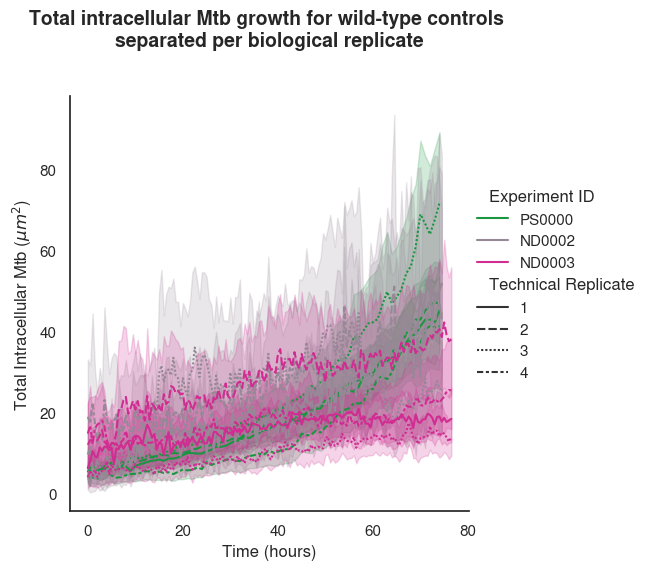

In [35]:
sns.relplot(
            data=df[(df['Compound'] == 'CTRL') & (df['Strain'] == 'WT')],
            x = 'Time (hours)', 
            y = 'Mtb Area (µm)',
            kind = 'line',
            hue = 'Experiment ID', 
            palette = [palette[0], palette[2], palette[-1]],
            style = 'Technical Replicate'
            )
plt.ylabel(r'Total Intracellular Mtb ($\mu m^2$)')
plt.title('Total intracellular Mtb growth for wild-type controls \nseparated per biological replicate', fontsize=14, fontweight=1000, y=1.1)
# plt.savefig(os.path.join(output_dir, 'Total intracellular Mtb growth for wild-type controls separated per biological replicate.pdf'), bbox_inches='tight', dpi=314)
# plt.show()  # Display the plot


In [14]:
f'Total intracellular Mtb growth for wild-type {compound} separated per technical and biological replicate.pdf'

'Total intracellular Mtb growth for wild-type BDQ separated per technical and biological replicate.pdf'

In [15]:
os.path.join(output_dir, f'Total intracellular Mtb growth for wild-type {compound} separated per technical and biological replicate.pdf')

'/mnt/SYNO/macrohet_syno/manuscript/results/Total intracellular Mtb growth for wild-type BDQ separated per technical and biological replicate.pdf'

<Figure size 640x480 with 0 Axes>

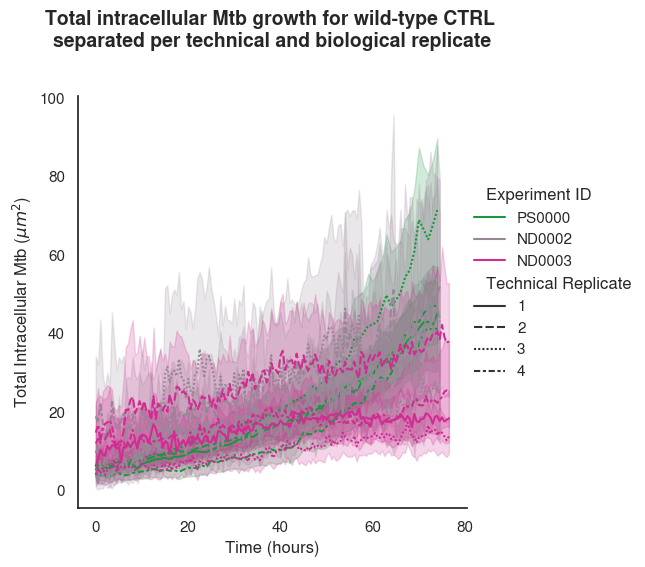

<Figure size 640x480 with 0 Axes>

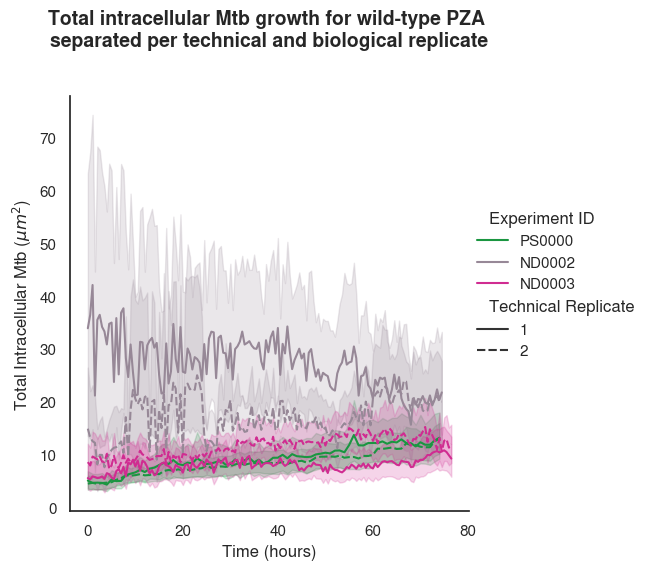

<Figure size 640x480 with 0 Axes>

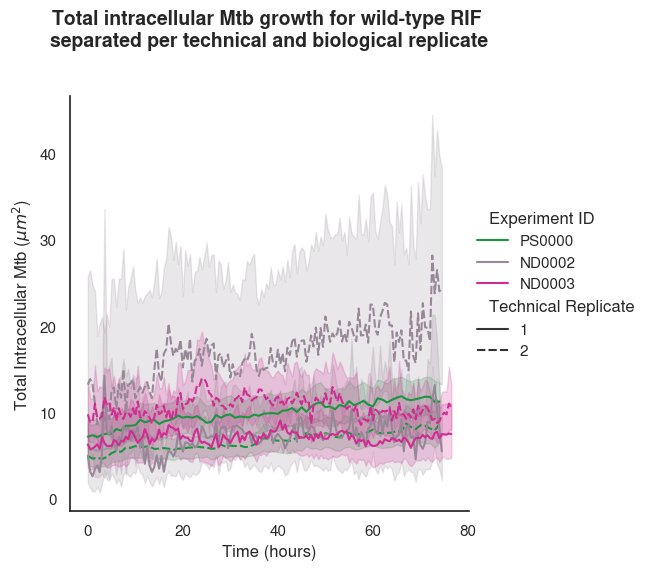

<Figure size 640x480 with 0 Axes>

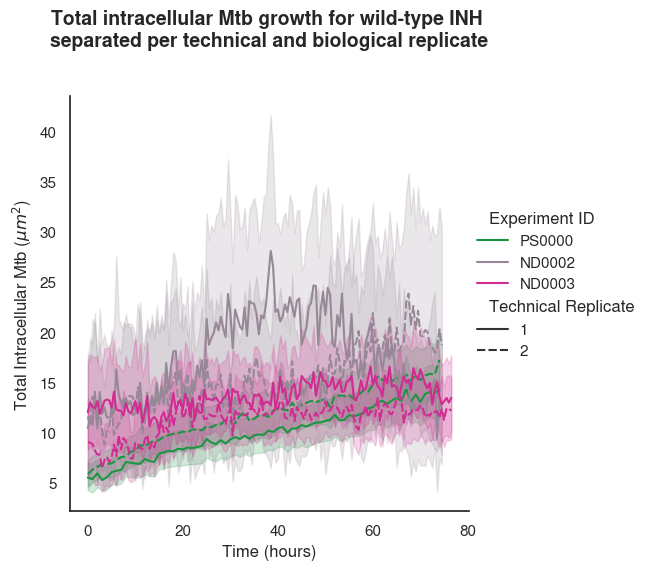

<Figure size 640x480 with 0 Axes>

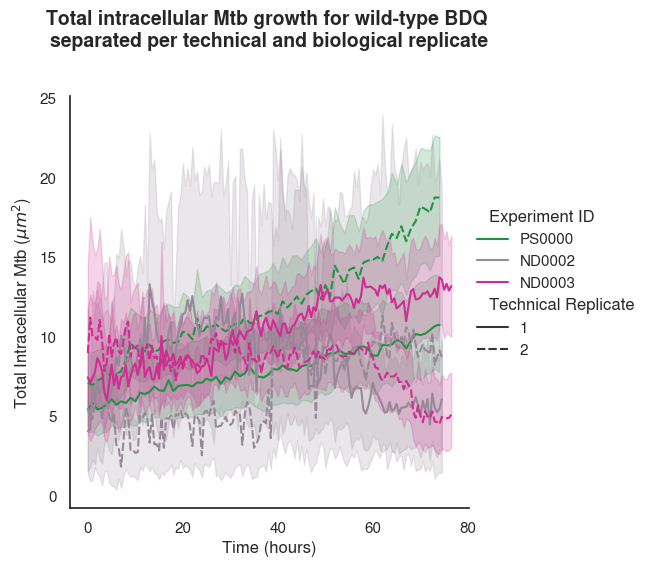

In [12]:
for compound in ['CTRL', 'PZA', 'RIF', 'INH', 'BDQ']:
    plt.clf()
    sns.relplot(
                data=df[(df['Compound'] == compound) & (df['Strain'] == 'WT')],
                x = 'Time (hours)', 
                y = 'Mtb Area (µm)',
                kind = 'line',
                hue = 'Experiment ID', 
                palette = [palette[0], palette[2], palette[-1]],
                    style = 'Technical Replicate'

                )
    plt.ylabel(r'Total Intracellular Mtb ($\mu m^2$)')
    plt.title(f'Total intracellular Mtb growth for wild-type {compound} \nseparated per technical and biological replicate', fontsize=14, fontweight=1000, y=1.1)
    plt.savefig(os.path.join(output_dir, f'Total intracellular Mtb growth for wild-type {compound} separated per technical and biological replicate.pdf'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


<Figure size 640x480 with 0 Axes>

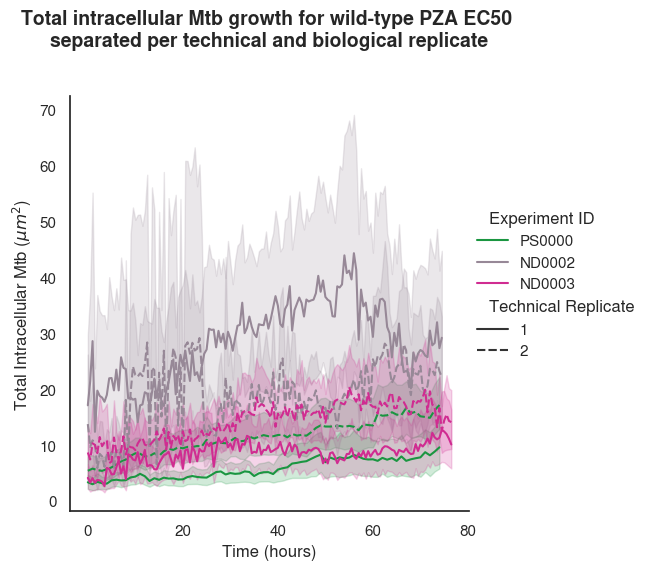

<Figure size 640x480 with 0 Axes>

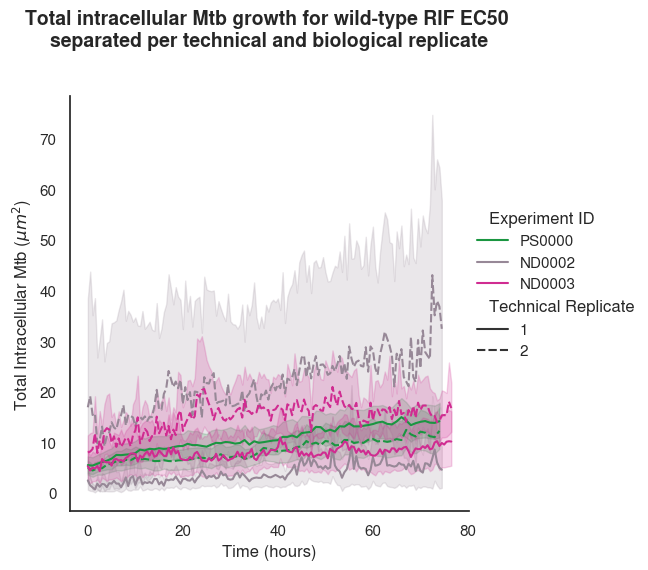

<Figure size 640x480 with 0 Axes>

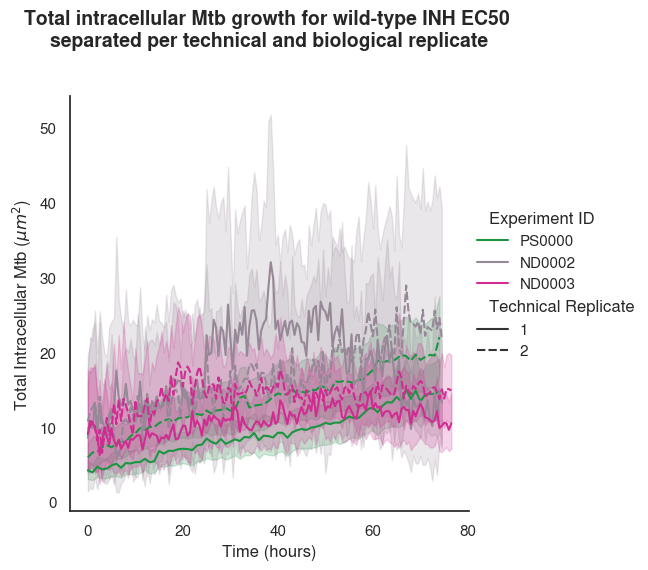

<Figure size 640x480 with 0 Axes>

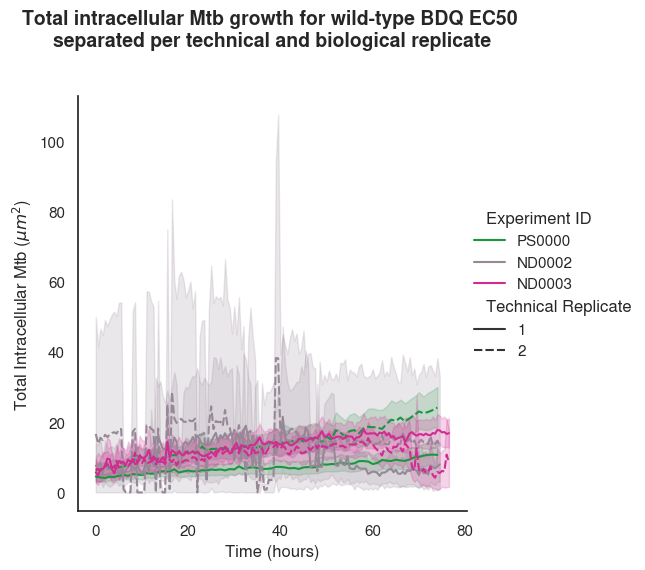

In [20]:
for compound in ['PZA', 'RIF', 'INH', 'BDQ']:
    plt.clf()
    sns.relplot(
                data=df[(df['Compound'] == compound) & (df['Strain'] == 'WT') & (df['Concentration'] == 'EC50')],
                x = 'Time (hours)', 
                y = 'Mtb Area (µm)',
                kind = 'line',
                hue = 'Experiment ID', 
                palette = [palette[0], palette[2], palette[-1]],
                    style = 'Technical Replicate'

                )
    plt.ylabel(r'Total Intracellular Mtb ($\mu m^2$)')
    plt.title(f'Total intracellular Mtb growth for wild-type {compound} EC50 \nseparated per technical and biological replicate', fontsize=14, fontweight=1000, y=1.1)
    plt.savefig(os.path.join(output_dir, f'Total intracellular Mtb growth for wild-type {compound} EC50 separated per technical and biological replicate.pdf'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


# RD1

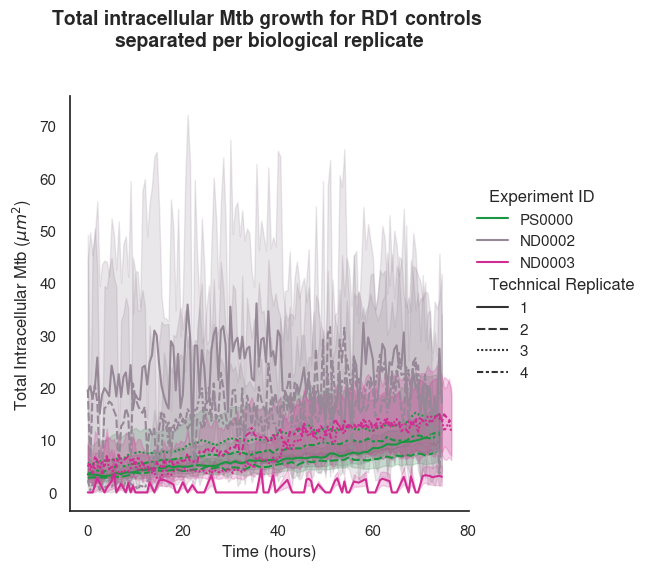

In [17]:
sns.relplot(
            data=df[(df['Compound'] == 'CTRL') & (df['Strain'] == 'RD1')],
            x = 'Time (hours)', 
            y = 'Mtb Area (µm)',
            kind = 'line',
            hue = 'Experiment ID', 
            palette = [palette[0], palette[2], palette[-1]],
            style = 'Technical Replicate'
            )
plt.ylabel(r'Total Intracellular Mtb ($\mu m^2$)')
plt.title('Total intracellular Mtb growth for RD1 controls \nseparated per biological replicate', fontsize=14, fontweight=1000, y=1.1)
plt.savefig(os.path.join(output_dir, 'Total intracellular Mtb growth for RD1 controls separated per biological replicate.pdf'), bbox_inches='tight', dpi=314)
# plt.show()  # Display the plot


<Figure size 640x480 with 0 Axes>

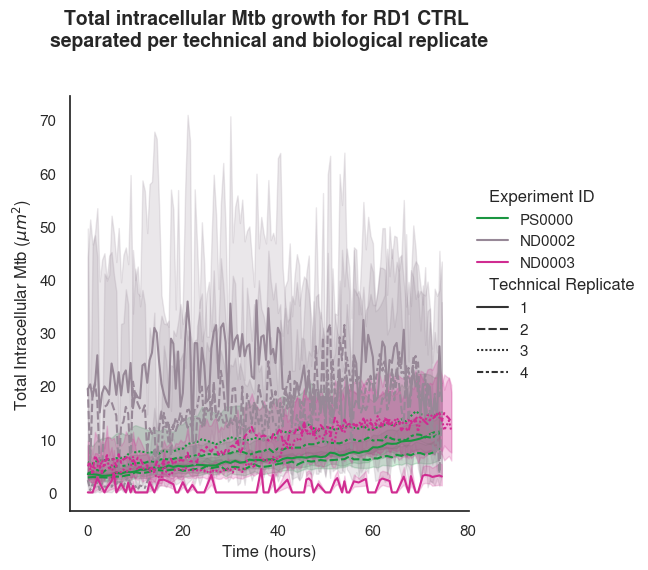

/tmp/ipykernel_69257/231194971.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

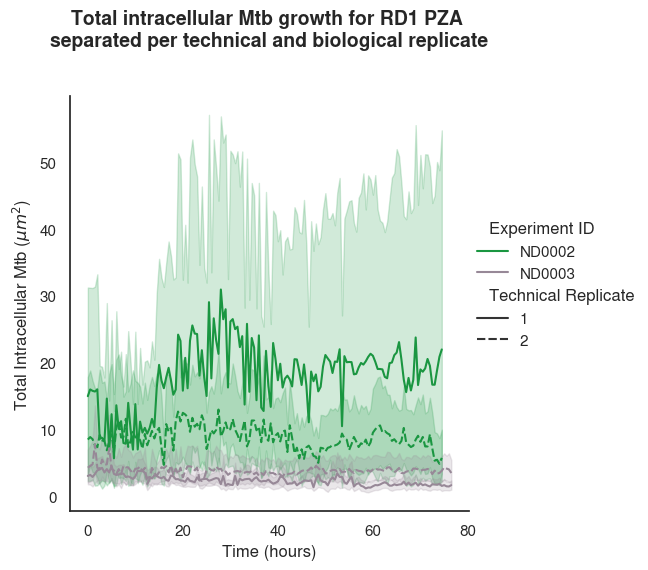

/tmp/ipykernel_69257/231194971.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

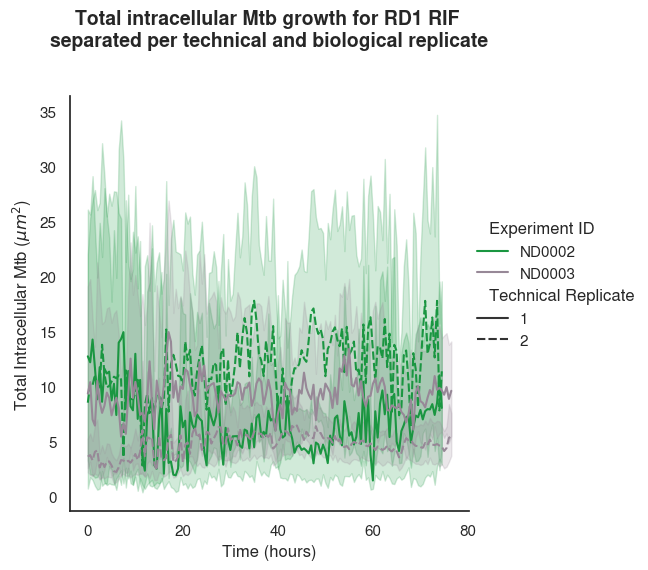

/tmp/ipykernel_69257/231194971.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

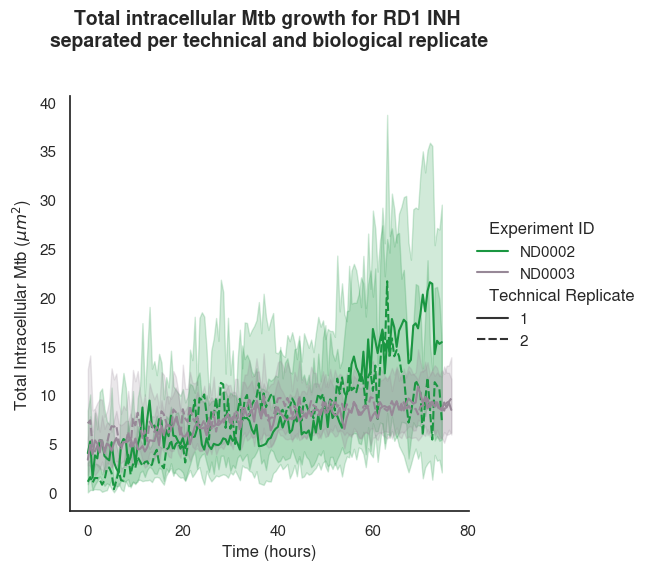

/tmp/ipykernel_69257/231194971.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

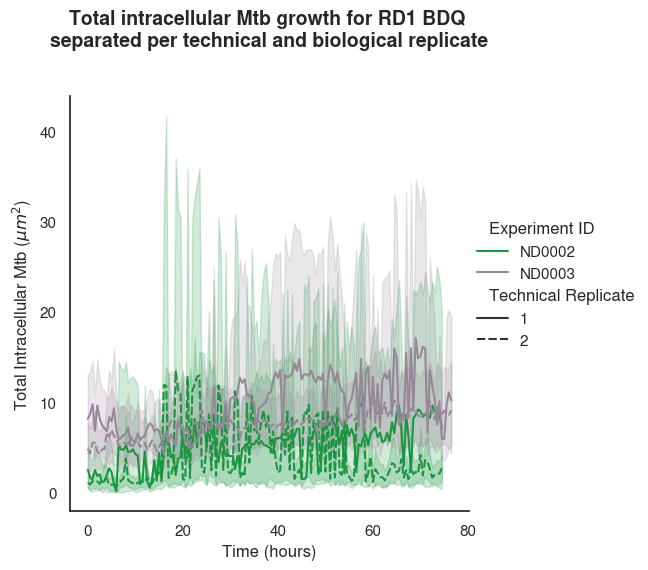

In [18]:
for compound in ['CTRL', 'PZA', 'RIF', 'INH', 'BDQ']:
    plt.clf()
    sns.relplot(
                data=df[(df['Compound'] == compound) & (df['Strain'] == 'RD1')],
                x = 'Time (hours)', 
                y = 'Mtb Area (µm)',
                kind = 'line',
                hue = 'Experiment ID', 
                palette = [palette[0], palette[2], palette[-1]],
                    style = 'Technical Replicate'

                )
    plt.ylabel(r'Total Intracellular Mtb ($\mu m^2$)')
    plt.title(f'Total intracellular Mtb growth for RD1 {compound} \nseparated per technical and biological replicate', fontsize=14, fontweight=1000, y=1.1)
    plt.savefig(os.path.join(output_dir, f'Total intracellular Mtb growth for RD1 {compound} separated per technical and biological replicate.pdf'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot

/tmp/ipykernel_69257/4008642500.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

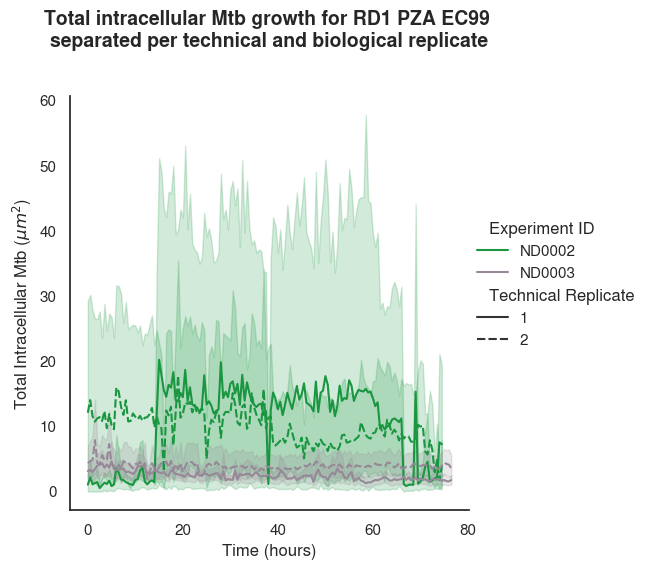

/tmp/ipykernel_69257/4008642500.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

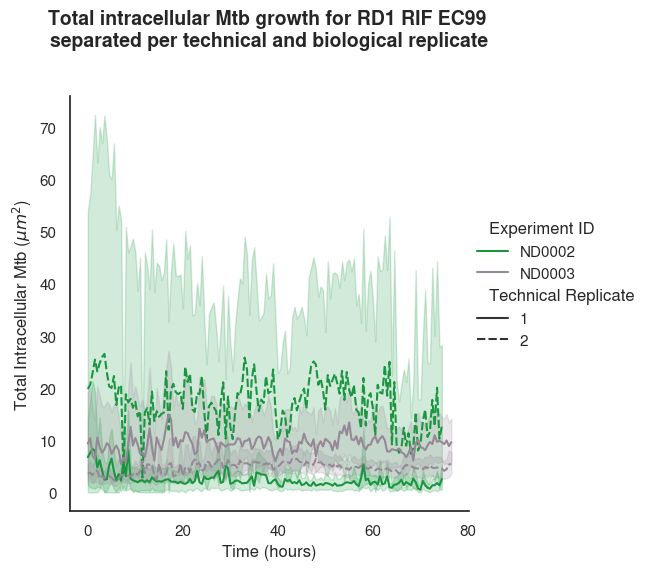

/tmp/ipykernel_69257/4008642500.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

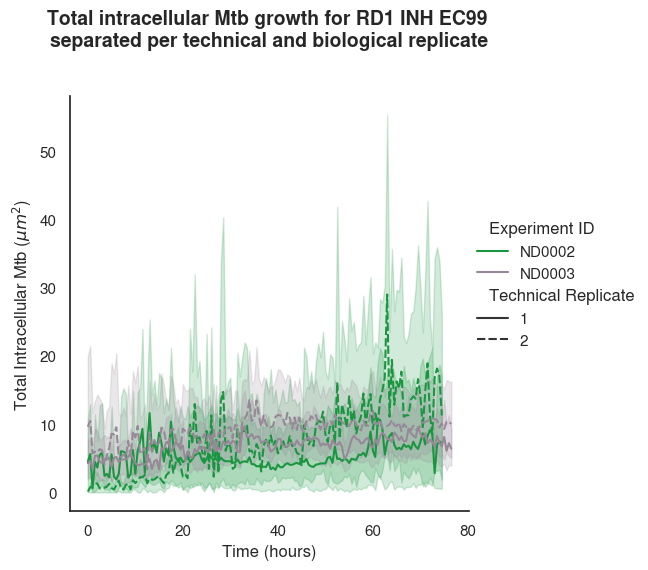

/tmp/ipykernel_69257/4008642500.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.relplot(


<Figure size 640x480 with 0 Axes>

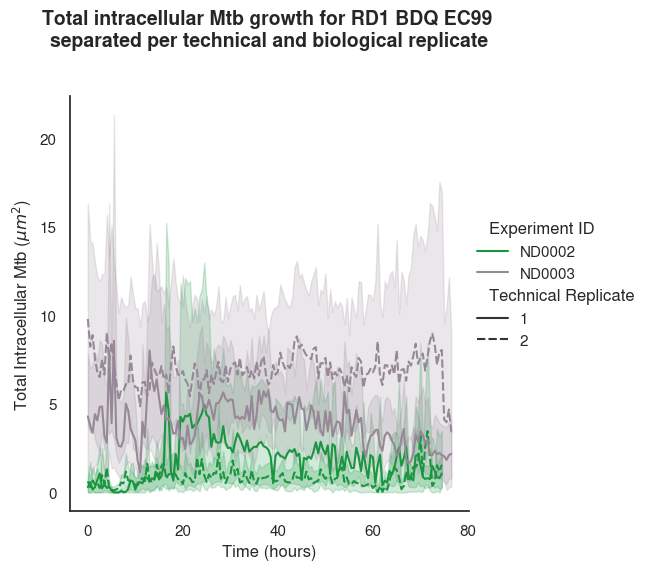

In [21]:
for compound in ['PZA', 'RIF', 'INH', 'BDQ']:
    plt.clf()
    sns.relplot(
                data=df[(df['Compound'] == compound) & (df['Strain'] == 'RD1') & (df['Concentration'] == 'EC99')],
                x = 'Time (hours)', 
                y = 'Mtb Area (µm)',
                kind = 'line',
                hue = 'Experiment ID', 
                palette = [palette[0], palette[2], palette[-1]],
                    style = 'Technical Replicate'

                )
    plt.ylabel(r'Total Intracellular Mtb ($\mu m^2$)')
    plt.title(f'Total intracellular Mtb growth for RD1 {compound} EC99 \nseparated per technical and biological replicate', fontsize=14, fontweight=1000, y=1.1)
    plt.savefig(os.path.join(output_dir, f'Total intracellular Mtb growth for RD1 {compound} EC99 separated per technical and biological replicate.pdf'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


No series to concat: (5, 3) RD1 ND2
No series to concat: (5, 4) RD1 ND2
No series to concat: (6, 3) RD1 ND2
No series to concat: (6, 4) RD1 ND2


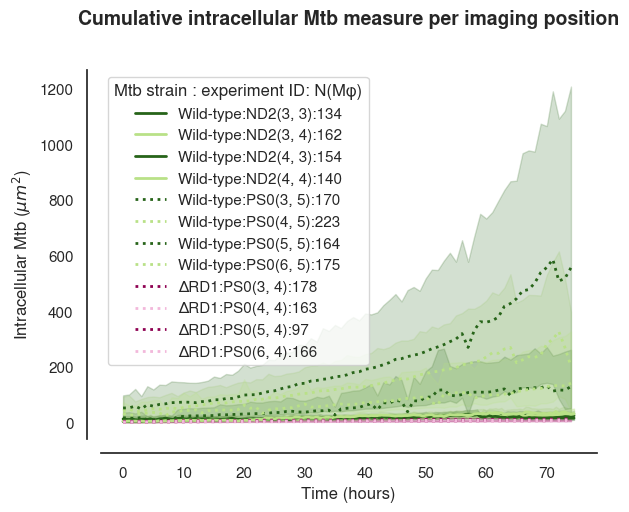

In [276]:
for expt_ID, linestyle in zip(expt_IDs, ['-', ':']):
    assay_layout = assay_layouts[expt_ID]
    # rfp_df = dfs[expt_ID]
    sc_df = sc_dfs[expt_ID]
    if sc_df.empty:
        continue
    for strain, colour_map in zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap]):
        # condition = 'WT'
        condition_indices = assay_layout[(assay_layout['Compound'] == 'CTRL') & (assay_layout['Strain'] == strain)].index
        
        # for (i,( index, linestyle)) in enumerate(zip(condition_indices, line_styles)):
        for i, (index, colour) in enumerate(zip(condition_indices, sns.palettes.color_palette(colour_map, n_colors=len(condition_indices)))):
            expt_ID = expt_ID.replace('000','')
            condition_label = str(formatting_dict[strain])
            subset_df = sc_df[sc_df['Acquisition ID'] == index]

            cleaned_concat_series = []
            
            for unique_ID in subset_df['Unique ID'].unique():
                # print(unique_ID)
                unique_ID_df = subset_df[subset_df['Unique ID'] == unique_ID]
                mtb_area = unique_ID_df['Mtb Area']
                cleaned_series = remove_outliers_iqr(mtb_area)
                time_indices = unique_ID_df['Time (hours)']
                cleaned_series = pd.concat([cleaned_series, time_indices], axis = 1)
                cleaned_concat_series.append(cleaned_series)
            if cleaned_concat_series == []:
                print('No series to concat:', index, strain, expt_ID)
                continue
            concat_series = pd.concat(cleaned_concat_series)
            N_cells = len(cleaned_concat_series)
            # concat_series = concat_series[concat_series.index % 1 == 0]
            
            # sns.set_palette(colour_map)
            sns.lineplot(
                data=concat_series,# * fluo_scaling_factor,
                x = 'Time (hours)', 
                y = 'Mtb Area',
                label=f'{condition_label}:{expt_ID}{index}:{N_cells}',
                linewidth=2,
                color = colour, 
                linestyle=linestyle,
                # alpha = 0.5 if condition == 'RD1' else 1,
                # cmap = colour_map
            )

sns.despine(offset=10)
# plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel(r'Intracellular Mtb ($\mu m^2$)')
plt.title('Cumulative intracellular Mtb measure per imaging position', fontsize=14, fontweight=1000, y=1.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), title = 'Mtb strain : experiment ID: N(Mφ)')  # Add a legend
plt.savefig(os.path.join(output_dir, 'single-cell_wild_type_RD1_per_position_growth.pdf'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot

# What are the outlying growth rates?

In [54]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import seaborn as sns

# Define the Richards growth model function
def richards_growth(t, K, N0, b, m):
    return K / (1 + ((K / N0 - 1) * np.exp(-b * t))**m)

# Define the Richards growth model function
def richards_growth(t, K, Q, B, v):
    return K / (1 + ((K / Q - 1) * np.exp(-B * t))**1/v)

def interpolate(data):
    valid = ~np.isnan(data)
    invalid = np.isnan(data)

    # Linearly interpolate missing (NaN) values
    data[invalid] = np.interp(np.flatnonzero(invalid), np.flatnonzero(valid), data[valid])

    return data

def replace_outlier(data):

    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find indices of outliers
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    # Use linear interpolation to replace outliers
    for index in outlier_indices:
        # Find indices of neighbors that are not outliers for interpolation
        if index == 0:  # Special case for the first element
            next_index = index + 1
            while next_index in outlier_indices and next_index < len(data) - 1:
                next_index += 1
            replacement_value = data[next_index]
        elif index == len(data) - 1:  # Special case for the last element
            prev_index = index - 1
            while prev_index in outlier_indices and prev_index > 0:
                prev_index -= 1
            replacement_value = data[prev_index]
        else:
            # For middle elements, find the closest non-outliers on both sides
            prev_index = index - 1
            next_index = index + 1
            while prev_index in outlier_indices and prev_index > 0:
                prev_index -= 1
            while next_index in outlier_indices and next_index < len(data) - 1:
                next_index += 1
            # Interpolate linearly between the neighbors
            replacement_value = (data[prev_index] + data[next_index]) / 2.0
    
        # Replace the outlier with the interpolated value
        data[index] = replacement_value
    
    return data

In [97]:


def plot(df, ID, p01, p02):
    """
    Analyzes bacterial growth using the Richards growth model.

    Parameters:
    - df: DataFrame containing the experimental data.
    - ID: The unique ID of the data set to be analyzed.
    - p01: Initial guess for parameter p01 of the Richards growth model.
    - p02: Initial guess for parameter p02 of the Richards growth model.
    """
    # Filter data based on ID
    sc_dt_df = df[df['ID'] == ID]
        
    # Extract bacterial population and time points
    bacterial_population = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)']
    bacterial_population = replace_outlier(bacterial_population.values)
    bacterial_population = interpolate(bacterial_population)
    time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)']

    # Fit the Richards growth model to the data
    initial_guess = [max(bacterial_population), min(bacterial_population), p01, p02]
    params, covariance = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess, full_output = True)
    K, N0, b, m = params

    # Create a time array for the model
    time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)
    
    # Calculate the model's bacterial population predictions
    population_model = richards_growth(time_model, K, N0, b, m)
    
    # Calculate the doubling points 
    doubling_series = []
    current_value = min(bacterial_population)
    while current_value <= max(bacterial_population):
        doubling_series.append(int(current_value))
        current_value *= 2
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(10, 6))
    plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
    plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])
    
    # Plot the horizontal lines from the doubling series
    for value in doubling_series:
        plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                    # label=f'Doubling Value: {value}')
    
    # Perform linear interpolation to estimate population values at intermediate time points
    interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
    interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
    interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
    
    # drop duplicate interpolated population values and corresponding time points
    unique_interpolated_time_points = []
    unique_interpolated_population = []
    
    # Initialize a set to keep track of seen population values
    seen_population_values = set()
    
    # Iterate through the lists and append unique population values
    for time, population in zip(interpolated_time_points, interpolated_population):
        if population not in seen_population_values:
            unique_interpolated_time_points.append(time)
            unique_interpolated_population.append(population)
            seen_population_values.add(population)
    
    # Find and mark the intersections between the interpolated population and the doubling series
    intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
    for t, N in intersections:
        plt.plot(t, N, 'ro')
    
    # # calculate the elapsed doubling times 
    # doubling_time_points = [t for (t, N) in intersections]
    # doubling_times = [doubling_time_points[i+1]-doubling_time_points[i] for i in range(len(doubling_time_points)-1)]
    # average_doubling_time = np.mean(doubling_times)
    # # Plot the vertical  lines from the doubling series
    # Assuming all previous steps are the same, focus on the calculation of doubling times:
    doubling_times = []
    for i in range(len(doubling_time_points) - 1):
        # Calculate the difference in time points
        time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
        # Calculate the difference in population
        population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
        # Check if the population is decreasing
        if population_diff < 0:
            # If so, make the time difference negative to indicate a decrease
            time_diff = -time_diff
        doubling_times.append(time_diff)
    
    # Now, doubling_times may include negative values, reflecting decreases in population
    average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
    
    # When plotting, adjust labels to reflect negative doubling times
    for i, time in enumerate(doubling_time_points):
        if i > 0:
            dt = doubling_times[i - 1]
            if dt < 0:
                label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
            else:
                label = f'dt to this point: {dt:.2f} hours'
            plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
    
    
    # for i, time in enumerate(doubling_time_points):
    #     if i == 0:
    #         plt.axvline(x=time, color=expanded_piyg[i], linestyle='--',)# label=f'Doubling time point: {time:.2f} hours')
    #     else:
    #         dt = doubling_times[i-1]
    #         plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=f'dt to this point: {dt:.2f} hours')
    # plt.xlim((int(interpolated_time_points[0]*0.8), int(interpolated_time_points[-1]*1.1)))
    # plt.ylim(min(bacterial_population)*0.9, max(bacterial_population)*1.1)
    # Add labels, legend, and title
    plt.xlabel('Time (hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
    cell_ID = sc_dt_df['Unique ID'].unique()
    plt.title(f'Cell ID {cell_ID} Doubling time plot\nParameters: K={K:.2f}, N0={N0:.2f}, b={b:.2f}, m={m:.2f}, p01={p01}, p02={p02}\nSimple doubling time calculation: {np.log(2)/b:.2f} hours\nMore accurate doubling time: {average_doubling_time:.2f} hours')
    sns.despine(offset = 10)
    # Show the plot
    plt.grid(False)

4.0


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

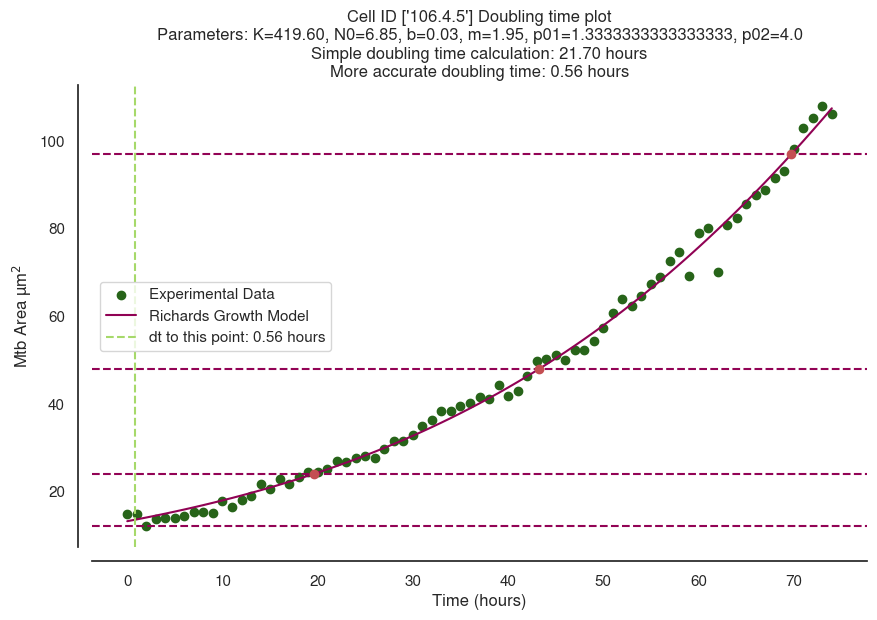

<Figure size 640x480 with 0 Axes>

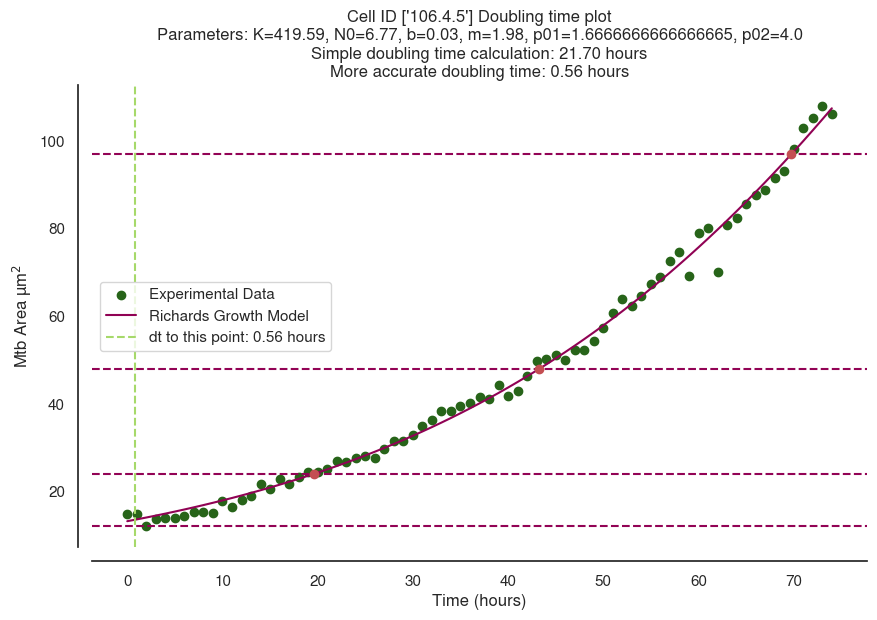

4.0


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

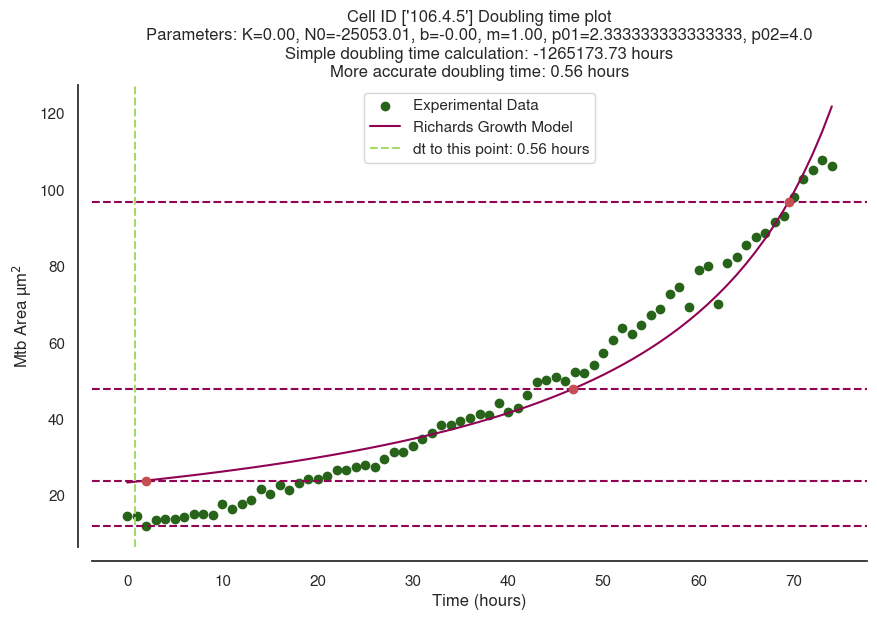

<Figure size 640x480 with 0 Axes>

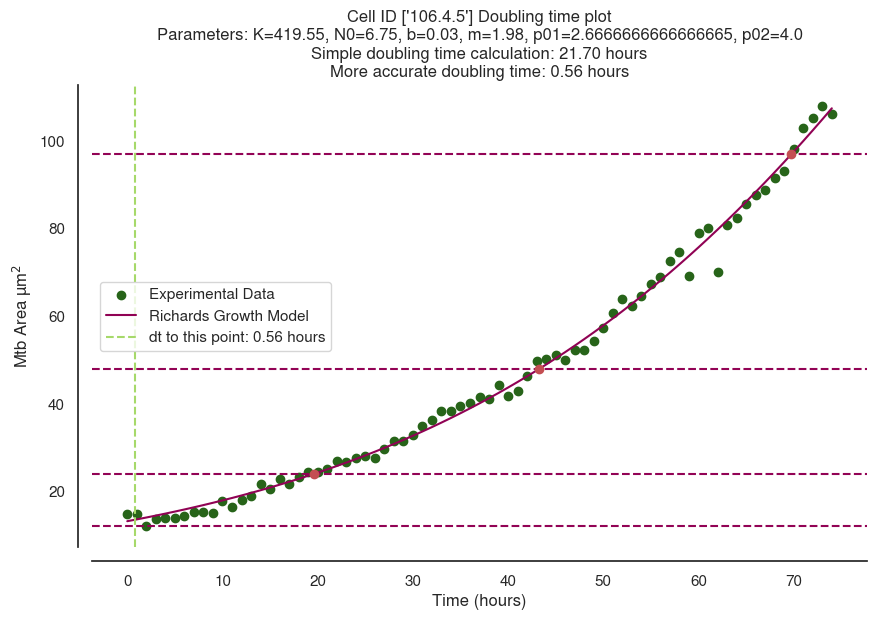

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


4.0
4.0


<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

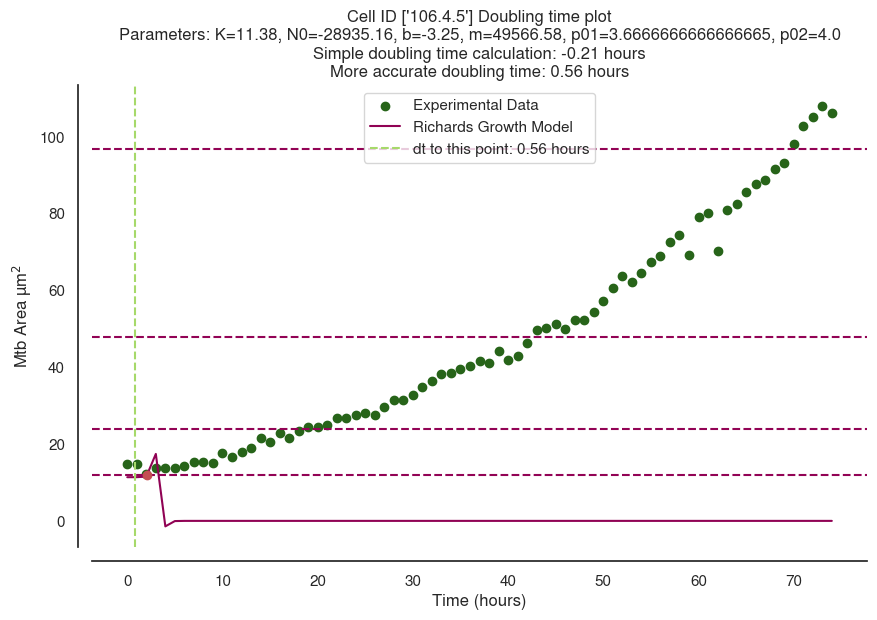

<Figure size 640x480 with 0 Axes>

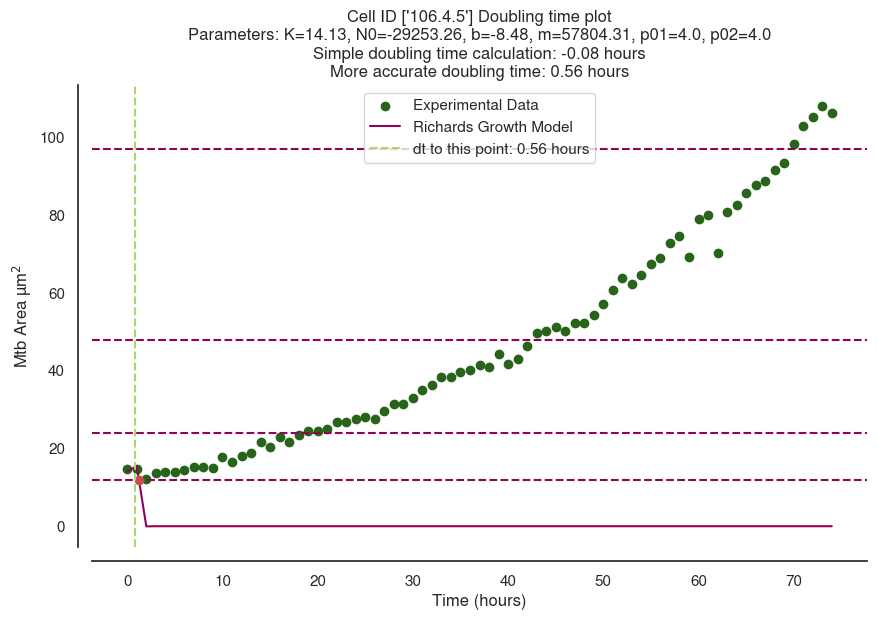

In [102]:
ID = '106.4.5.PS0000'

for p01 in np.linspace(1,4,10):
    plt.clf()
    try:
        plot(df, ID, p01, p02)
        plt.show()
    except:
        print(p02)

In [ ]:
os.makedirs(os.path.join(output_dir, f'dt_dev/smol/'), exist_ok = True)
os.makedirs(os.path.join(output_dir, f'dt_dev/nan/'), exist_ok = True)
unique_IDs = df['ID'].unique()
problem_IDs = []
random.shuffle(unique_IDs)

for unique_ID in tqdm(unique_IDs):
    try:
    
        sc_dt_df = df[df['ID'] == unique_ID]

        # if glob.glob(os.path.join(output_dir, f'dt_dev/*/cell_ID.{unique_ID}_doubling_time_WIP_calcs.pdf')):
        #     print(unique_ID, 'already attempted')
        #     continue 
            
        bacterial_population = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Mtb Area (µm)'] 
        bacterial_population = replace_outlier(bacterial_population.values)
        bacterial_population = interpolate(bacterial_population)
        
        time_points = sc_dt_df[sc_dt_df['Mtb Area (µm)'] != 0]['Time (hours)'] 
        
        # Fit the Richards growth model to the data
        initial_guess = [max(bacterial_population), min(bacterial_population), 0.1, 3]  # Initial parameter guesses
        params, covariance = curve_fit(richards_growth, time_points, bacterial_population, p0=initial_guess)
        
        # Extract the model parameters
        K, N0, b, m = params
        
        # Create a time array for the model
        time_model = np.linspace(0, len(bacterial_population)-1, len(time_points)) # np.linspace(0, len(bacterial_population)-1, 100)
        
        # Calculate the model's bacterial population predictions
        population_model = richards_growth(time_model, K, N0, b, m)
        
        # Calculate the doubling points 
        doubling_series = []
        current_value = min(bacterial_population)
        while current_value <= max(bacterial_population):
            doubling_series.append(int(current_value))
            current_value *= 2
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(10, 6))
        plt.scatter(time_points, bacterial_population, label='Experimental Data', color=green_colors[0])
        plt.plot(time_model, population_model, label='Richards Growth Model', color=pink_colors[1])
        
        # Plot the horizontal lines from the doubling series
        for value in doubling_series:
            plt.axhline(y=value, color=pink_colors[2], linestyle='--',) 
                        # label=f'Doubling Value: {value}')
        
        # Perform linear interpolation to estimate population values at intermediate time points
        interpolator = interp1d(time_model, population_model, kind='linear', fill_value='extrapolate')
        interpolated_time_points = np.linspace(min(time_points), max(time_points), num=int(max(population_model))*100) # the number of points needs to be granular enough to cover every integer between min and max population values as then all intersections can be reliably found 
        interpolated_population = [int(i) for i in interpolator(interpolated_time_points)]
        
        # drop duplicate interpolated population values and corresponding time points
        unique_interpolated_time_points = []
        unique_interpolated_population = []
        
        # Initialize a set to keep track of seen population values
        seen_population_values = set()
        
        # Iterate through the lists and append unique population values
        for time, population in zip(interpolated_time_points, interpolated_population):
            if population not in seen_population_values:
                unique_interpolated_time_points.append(time)
                unique_interpolated_population.append(population)
                seen_population_values.add(population)
        
        # Find and mark the intersections between the interpolated population and the doubling series
        intersections = [(t, N) for t, N in zip(unique_interpolated_time_points, unique_interpolated_population) if N in doubling_series]
        for t, N in intersections:
            plt.plot(t, N, 'ro')
        
        # # calculate the elapsed doubling times 
        doubling_time_points = [t for (t, N) in intersections]
        
        # doubling_times = [doubling_time_points[i+1]-doubling_time_points[i] for i in range(len(doubling_time_points)-1)]
        # average_doubling_time = np.mean(doubling_times)
        # # Plot the vertical  lines from the doubling series
        # Assuming all previous steps are the same, focus on the calculation of doubling times:
        doubling_times = []
        for i in range(len(doubling_time_points) - 1):
            # Calculate the difference in time points
            time_diff = doubling_time_points[i + 1] - doubling_time_points[i]
            # Calculate the difference in population
            population_diff = unique_interpolated_population[i + 1] - unique_interpolated_population[i]
            # Check if the population is decreasing
            if population_diff < 0:
                # If so, make the time difference negative to indicate a decrease
                time_diff = -time_diff
            doubling_times.append(time_diff)
        
        # Now, doubling_times may include negative values, reflecting decreases in population
        average_doubling_time = np.mean([(time) for time in doubling_times])  # Use absolute values for average
        
        # When plotting, adjust labels to reflect negative doubling times
        for i, time in enumerate(doubling_time_points):
            if i > 0:
                dt = doubling_times[i - 1]
                if dt < 0:
                    label = f'dt to this point: -{abs(dt):.2f} hours (decrease)'
                else:
                    label = f'dt to this point: {dt:.2f} hours'
                plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=label)
        
        
        # for i, time in enumerate(doubling_time_points):
        #     if i == 0:
        #         plt.axvline(x=time, color=expanded_piyg[i], linestyle='--',)# label=f'Doubling time point: {time:.2f} hours')
        #     else:
        #         dt = doubling_times[i-1]
        #         plt.axvline(x=time, color=expanded_piyg[i], linestyle='--', label=f'dt to this point: {dt:.2f} hours')
        
        plt.xlim((int(interpolated_time_points[0]*0.9), int(interpolated_time_points[-1]*1.1)))
        plt.ylim(min(bacterial_population)*0.9, max(bacterial_population)*1.1)

        # Add labels, legend, and title
        plt.xlabel('Time (hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        cell_ID = sc_dt_df['Unique ID'].unique()
        plt.title(f'Cell ID {cell_ID} Doubling time plot\nParameters: K={K:.2f}, N0={N0:.2f}, b={b:.2f}, m={m:.2f}\nSimple doubling time calculation: {np.log(2)/b:.2f} hours\nMore accurate doubling time: {average_doubling_time:.2f} hours')
        sns.despine(offset = 10)
        # Show the plot
        plt.grid(False)
        
        if np.isnan(average_doubling_time):
            plt.savefig(os.path.join(output_dir, f'dt_dev/nan/cell_ID.{unique_ID}_doubling_time_WIP_calcs.png'), dpi =314, bbox_inches = 'tight')
            print(f'Simple doubling time calculation: {np.log(2)/b:.2f} hours')
            print(f'More accurate doubling time: {average_doubling_time:.2f} hours')
            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))
            continue
        if doubling_series[0] < 1.966664663680242: # consider this to be less than one bac
            plt.savefig(os.path.join(output_dir, f'dt_dev/smol/cell_ID.{unique_ID}_doubling_time_WIP_calcs.png'), dpi =314, bbox_inches = 'tight')
            print(f'Simple doubling time calculation: {np.log(2)/b:.2f} hours')
            print(f'More accurate doubling time: {average_doubling_time:.2f} hours')
            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))
            continue
        else:
            plt.savefig(os.path.join(output_dir, f'dt_dev/cell_ID.{unique_ID}_doubling_time_WIP_calcs.png'), dpi =314, bbox_inches = 'tight')
            print(f'Simple doubling time calculation: {np.log(2)/b:.2f} hours')
            print(f'More accurate doubling time: {average_doubling_time:.2f} hours')
            df.loc[df['ID'] == unique_ID, 'dt'] = average_doubling_time
            df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))
            continue
        # plt.show()
        
    except Exception as e: 
        print(unique_ID, e)
        problem_IDs.append(unique_ID)
        df.loc[df['Unique ID'] == unique_ID, 'dt'] = np.nan
        df.to_pickle(os.path.join(output_dir, 'dt_df.pkl'))

In [96]:
average_doubling_time

nan

In [26]:
dt_df = pd.read_pickle(os.path.join(output_dir, 'dt_df.pkl'))

In [27]:
dt_df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                 0.0       0.424621       -0.424621      459.082108   
1                 1.0       0.000000       -0.424621      372.839393   
2                 2.0       0.000000       -0.424621      423.168130   
3                 3.0       0.335227       -0.424621      445.561289   
4                 4.0       0.000000       -0.424621      487.040034   
...               ...            ...             ...             ...   
1722130          74.5       1.117423        1.095075      752.584461   
1722131          75.0       2.033710        1.095075      616.035357   
1722132          75.5       1.430302        1.095075      579.182743   
1722133          76.0       1.989013        1.095075      679.147414   
1722134          76.5       2.123104        1.095075      770.686715   

         dMphi Area (µm)  Infection Status  Initial Infection Status  \
0             -92.746118               1.0                       1.0   
1             -92.746118               0.0                       1.0   
2             -92.746118               0.0                       1.0   
3             -92.746118               1.0                       1.0   
4             -92.746118               1.0                       1.0   
...                  ...               ...                       ...   
1722130        55.088959               1.0                       1.0   
1722131        55.088959               1.0                       1.0   
1722132        55.088959               1.0                       1.0   
1722133        55.088959               1.0                       1.0   
1722134        55.088959               1.0                       1.0   

         Final Infection Status           x           y  ...  \
0                           0.0  457.172943    8.791715  ...   
1                           0.0  459.138947    6.718642  ...   
2                           0.0  460.555237   10.785886  ...   
3                           0.0  455.878815   11.143067  ...   
4                           0.0  462.634186   14.050420  ...   
...                         ...         ...         ...  ...   
1722130                     1.0  227.093262  130.358139  ...   
1722131                     1.0  226.622925  130.532120  ...   
1722132                     1.0  225.366608  129.932709  ...   
1722133                     1.0  226.424683  128.489410  ...   
1722134                     1.0  225.741119  126.533669  ...   

         Biological Replicate  Strain  Compound  Concentration  Cell ID  \
0                           1     RD1      CTRL            EC0      426   
1                           1     RD1      CTRL            EC0      426   
2                           1     RD1      CTRL            EC0      426   
3                           1     RD1      CTRL            EC0      426   
4                           1     RD1      CTRL            EC0      426   
...                       ...     ...       ...            ...      ...   
1722130                     3     RD1       BDQ           EC99     1874   
1722131                     3     RD1       BDQ           EC99     1874   
1722132                     3     RD1       BDQ           EC99     1874   
1722133                     3     RD1       BDQ           EC99     1874   
1722134                     3     RD1       BDQ           EC99     1874   

         Acquisition ID Experiment ID  Unique ID                ID        dt  
0                (3, 4)        PS0000    426.3.4    426.3.4.PS0000  8.940671  
1                (3, 4)        PS0000    426.3.4    426.3.4.PS0000  8.940671  
2                (3, 4)        PS0000    426.3.4    426.3.4.PS0000  8.940671  
3                (3, 4)        PS0000    426.3.4    426.3.4.PS0000  8.940671  
4                (3, 4)        PS0000    426.3.4    426.3.4.PS0000  8.940671  
...                 ...           ...        ...               ...       ...  
1722130         (6, 12)        ND0003  1874.6.12  1874.6

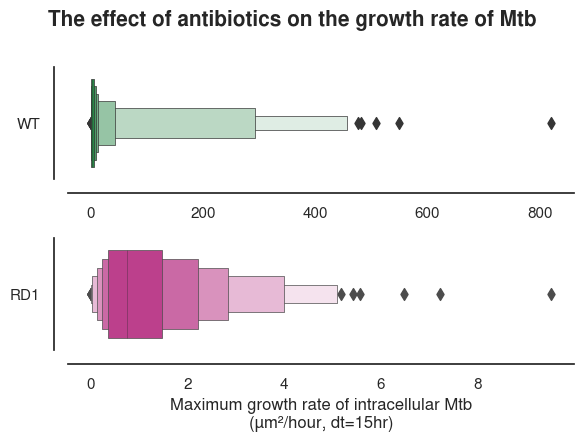

In [810]:
subset_df = df[df['Compound']=='CTRL']
subset_df['Acquisition ID'].unique()

# Create a figure with two vertically stacked subplots
fig, axes = plt.subplots(nrows=2, figsize=(6,4))

# Define palette colors
palette_colors = [expanded_piyg[0], expanded_piyg[-1]]

# Plot the first boxenplot (WT)
sns.boxenplot(
    x="Max. dMtb/dt,T=15", 
    y="Strain",
    hue="Strain",
    palette=[palette_colors[0]],
    data=subset_df.drop_duplicates('Max. dMtb/dt,T=15')[subset_df.drop_duplicates('Max. dMtb/dt,T=15')['Strain'] == 'WT'], 
    scale='linear',
        linewidth = linewidth,
    ax=axes[0]  # Use the first subplot
)
axes[0].set_xlabel("")
axes[0].set_ylabel("")  # Set the y-axis label

# Remove legend and title for the first subplot
axes[0].legend().set_visible(False)
axes[0].set_title('')

# Plot the second boxenplot (RD1)
sns.boxenplot(
    x="Max. dMtb/dt,T=15", 
    y="Strain",
    hue="Strain",
    palette=[palette_colors[1]],
    data=subset_df.drop_duplicates('Max. dMtb/dt,T=15')[subset_df.drop_duplicates('Max. dMtb/dt,T=15')['Strain'] == 'RD1'], 
    scale='linear',
        linewidth = linewidth,
    ax=axes[1]  # Use the second subplot
)
axes[1].set_xlabel("Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)")
axes[1].set_ylabel("")  # Remove the y-axis label for the second subplot

# Remove legend and title for the second subplot
axes[1].legend().set_visible(False)
axes[1].set_title('')

sns.despine(offset=10)
# Adjust spacing between subplots
plt.tight_layout()

plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.1)
plt.savefig(os.path.join(output_dir, 'max_growth_rate_outliers_boxenplot.pdf'), bbox_inches = 'tight', dpi = 314)
# Show the combined plot
plt.show()

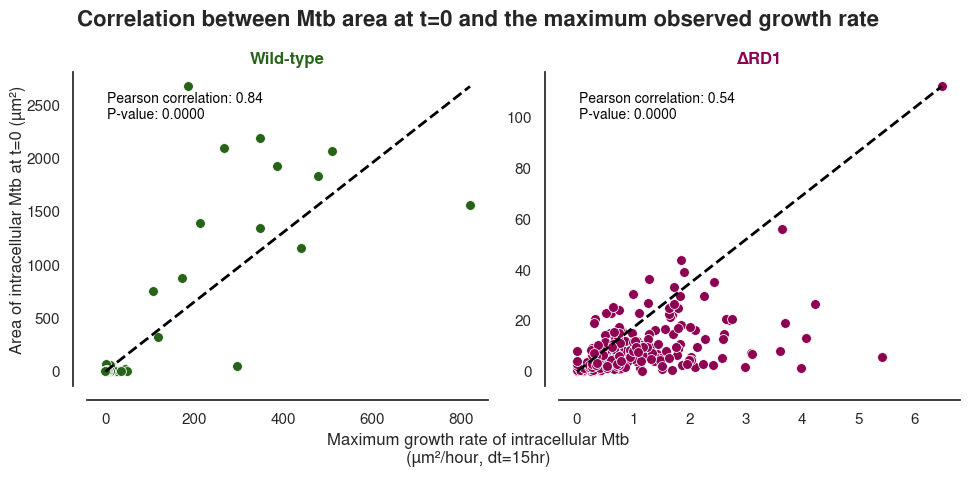

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Assuming subset_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain, colour_map) in enumerate(zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap])):
    filtered_df = subset_df[(subset_df['Strain'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['Max. dMtb/dt,T=15']

    exluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0< n]#<600]
    N0 = [i[0] for i in exluding_outliers]
    max_gr = [i[1] for i in exluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i], color=colour_map[0], s = 50, label='')#'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i].set_xlabel("")  # Clear the individual x-labels
    axes[i].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}"
                     , xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i].set_title('ΔRD1' if strain != 'WT' else 'Wild-type', color=colour_map[0], fontweight = 'bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm\u00b2)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the maximum observed growth rate', fontweight = 'bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(base_dir, 'manuscript/N0_maxdmtbdt_control.pdf'), bbox_inches = 'tight', dpi = 314)
# Display the plot
plt.show()


# which dt examples do i have glimpses for

In [202]:
os.path.join(output_dir, f'dt_dev/smol/cell_ID:*doubling_time_WIP_calcs.pdf')

'/mnt/SYNO/macrohet_syno/manuscript/dt_dev/smol/cell_ID:*doubling_time_WIP_calcs.pdf'

In [208]:
fns = glob.glob(os.path.join(output_dir, f'dt_dev/cell_ID*doubling_time_WIP_calcs.pdf'))
fn = fns[0]

In [216]:
# Define the pattern to match the file names
pattern = re.compile(r'\[(.*?)\]')
match = pattern.search(fn).group(1).replace("'", "")

In [219]:
IDs = [pattern.search(fn).group(1).replace("'", "") for fn in fns]

In [294]:
glob_strs = [f'/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/{ID}.mp4' for ID in IDs]

In [295]:
fn

'/mnt/DATA/macrohet/PS0000/results/glimpses/fast_grower_area_graph/(5, 8)/99.5.8'

In [296]:
for ID in IDs:
    r,c = int(ID.split('.')[1]),int(ID.split('.')[2])
    fn = f'/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/{ID}.mp4'
    if os.path.exists(fn):
        print(fn)

/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/1.3.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/1.4.9.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/10.4.6.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/100.3.4.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/102.5.8.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/103.4.9.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/103.6.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/104.6.7.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.4.9.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.5.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.6.4.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/105.6.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/106.4.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/106.6.4.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/108.5.5.mp4
/mnt/SYNO/macrohet_syno/manuscript/dt_dev_glimpses/11.4.8.mp

### Checking if N from doubling series is in interpolated population

In [1215]:
type(average_doubling_time)

numpy.float64

In [32]:
dt_df = pd.read_pickle('/mnt/SYNO/macrohet_syno/manuscript/dt_df.pkl')

In [33]:
dt_df

Time (hours)   Mtb Area        dMtb Strain Compound Concentration  \
0                  0  46.797680  136.772588     WT     CTRL           EC0   
1                  1  48.719647  136.772588     WT     CTRL           EC0   
2                  2  52.206007  136.772588     WT     CTRL           EC0   
3                  3  50.552221  136.772588     WT     CTRL           EC0   
4                  4  54.463202  136.772588     WT     CTRL           EC0   
...              ...        ...         ...    ...      ...           ...   
296992            70   0.000000   -3.888632     WT     CTRL           EC0   
296993            71   0.000000   -3.888632     WT     CTRL           EC0   
296994            72   0.000000   -3.888632     WT     CTRL           EC0   
296995            73   0.000000   -3.888632     WT     CTRL           EC0   
296996            74   0.000000   -3.888632     WT     CTRL           EC0   

       Unique ID Acquisition ID  Cell ID  Mphi Area  ...  Infection Status  \
0          1.3.5         (3, 5)        1    29567.0  ...              True   
1          1.3.5         (3, 5)        1    26181.0  ...              True   
2          1.3.5         (3, 5)        1    26043.0  ...              True   
3          1.3.5         (3, 5)        1    25605.0  ...              True   
4          1.3.5         (3, 5)        1    26430.0  ...              True   
...          ...            ...      ...        ...  ...               ...   
296992   996.4.5         (4, 5)      996    32533.0  ...              True   
296993   996.4.5         (4, 5)      996    31403.0  ...              True   
296994   996.4.5         (4, 5)      996    33239.0  ...              True   
296995   996.4.5         (4, 5)      996    42445.0  ...              True   
296996   996.4.5         (4, 5)      996    35463.0  ...              True   

        Initial Infection Status  Final Infection Status  dMtb/dt,T=15  \
0                           True                    True           NaN   
1                           True                    True           NaN   
2                           True                    True           NaN   
3                           True                    True           NaN   
4                           True                    True           NaN   
...                          ...                     ...           ...   
296992                      True                   False           0.0   
296993                      True                   False           0.0   
296994                      True                   False           0.0   
296995                      True                   False           0.0   
296996                      True                   False           0.0   

        Max. dMtb/dt,T=15         dt           K         N0        b        m  
0                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
1                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
2                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
3                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
4                6.314185  35.572443  265.591737  15.549781  0.05123  0.52539  
...                   ...        ...         ...        ...      ...      ...  
296992           0.064066        NaN        None       None     None     None  
296993           0.064066        NaN        None       None     None     None  
296994           0.064066        NaN        None       None     None     None  
296995           0.064066        NaN        None       None     None     None  
296996           0.064066        NaN        None       None     None     None  

[291526 rows x 32 columns]

In [28]:
dt_df['Acquisition ID'].unique()

array([(3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 4), (4, 5),
       (4, 6), (4, 7), (4, 8), (4, 9), (5, 4), (5, 5), (5, 6), (5, 7),
       (5, 8), (5, 9), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9),
       (3, 1), (3, 2), (3, 3), (3, 10), (3, 11), (3, 12), (4, 3), (4, 10),
       (4, 11), (4, 12), (5, 3), (5, 10), (5, 11), (5, 12), (6, 10),
       (6, 11), (6, 12), (6, 3)], dtype=object)

(array([4767., 7533., 9992., 9633., 6864., 3432., 2466., 2393., 2017.,
        1047.]),
 array([ 0.28087726,  7.47294679, 14.66501632, 21.85708585, 29.04915538,
        36.24122491, 43.43329444, 50.62536396, 57.81743349, 65.00950302,
        72.20157255]),
 <BarContainer object of 10 artists>)

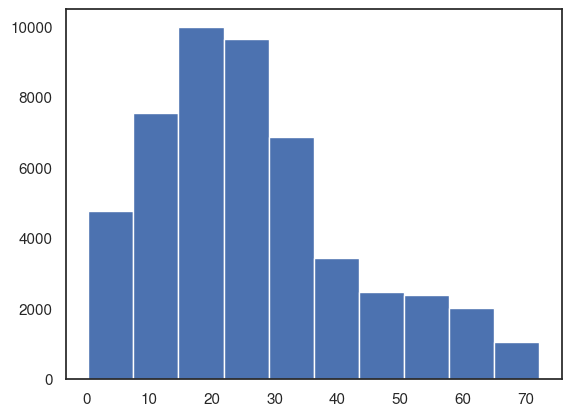

In [34]:
plt.hist(dt_df['dt'])

<Axes: xlabel='dt', ylabel='Count'>

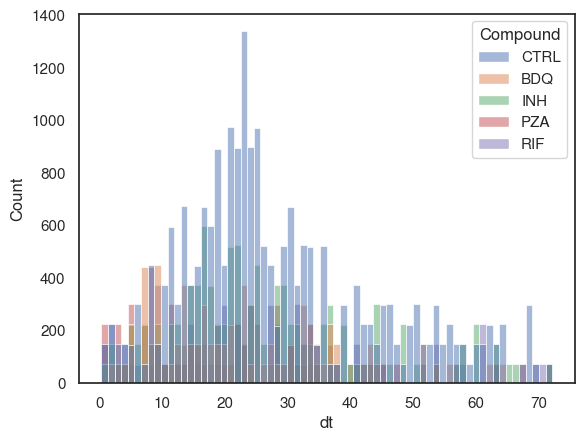

In [35]:
sns.histplot(data = dt_df, x = 'dt', hue = 'Compound')

<Axes: xlabel='dt'>

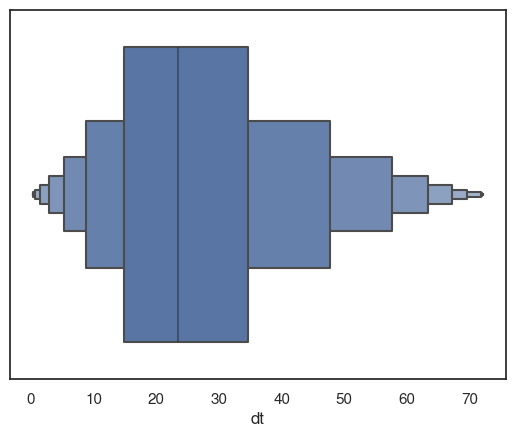

In [310]:
sns.boxenplot(data = dt_df, x = 'dt', hue = 'Compound', )#col='ConcentrationEC')

In [36]:
df

Time (hours)  Mtb Area (µm)  dMtb Area (µm)  Mphi Area (µm)  \
0                 0.0       0.424621       -0.424621      459.082108   
1                 1.0       0.000000       -0.424621      372.839393   
2                 2.0       0.000000       -0.424621      423.168130   
3                 3.0       0.335227       -0.424621      445.561289   
4                 4.0       0.000000       -0.424621      487.040034   
...               ...            ...             ...             ...   
1722130          74.5       1.117423        1.095075      752.584461   
1722131          75.0       2.033710        1.095075      616.035357   
1722132          75.5       1.430302        1.095075      579.182743   
1722133          76.0       1.989013        1.095075      679.147414   
1722134          76.5       2.123104        1.095075      770.686715   

         dMphi Area (µm)  Infection Status  Initial Infection Status  \
0             -92.746118               1.0                       1.0   
1             -92.746118               0.0                       1.0   
2             -92.746118               0.0                       1.0   
3             -92.746118               1.0                       1.0   
4             -92.746118               1.0                       1.0   
...                  ...               ...                       ...   
1722130        55.088959               1.0                       1.0   
1722131        55.088959               1.0                       1.0   
1722132        55.088959               1.0                       1.0   
1722133        55.088959               1.0                       1.0   
1722134        55.088959               1.0                       1.0   

         Final Infection Status           x           y  ...  \
0                           0.0  457.172943    8.791715  ...   
1                           0.0  459.138947    6.718642  ...   
2                           0.0  460.555237   10.785886  ...   
3                           0.0  455.878815   11.143067  ...   
4                           0.0  462.634186   14.050420  ...   
...                         ...         ...         ...  ...   
1722130                     1.0  227.093262  130.358139  ...   
1722131                     1.0  226.622925  130.532120  ...   
1722132                     1.0  225.366608  129.932709  ...   
1722133                     1.0  226.424683  128.489410  ...   
1722134                     1.0  225.741119  126.533669  ...   

         Technical Replicate  Biological Replicate  Strain  Compound  \
0                          1                     1     RD1      CTRL   
1                          1                     1     RD1      CTRL   
2                          1                     1     RD1      CTRL   
3                          1                     1     RD1      CTRL   
4                          1                     1     RD1      CTRL   
...                      ...                   ...     ...       ...   
1722130                    2                     3     RD1       BDQ   
1722131                    2                     3     RD1       BDQ   
1722132                    2                     3     RD1       BDQ   
1722133                    2                     3     RD1       BDQ   
1722134                    2                     3     RD1       BDQ   

         Concentration  Cell ID Acquisition ID Experiment ID  Unique ID  \
0                  EC0      426         (3, 4)        PS0000    426.3.4   
1                  EC0      426         (3, 4)        PS0000    426.3.4   
2                  EC0      426         (3, 4)        PS0000    426.3.4   
3                  EC0      426         (3, 4)        PS0000    426.3.4   
4                  EC0      426         (3, 4)        PS0000    426.3.4   
...                ...      ...            ...           ...        ...   
1722130           EC99     1874        (6, 12)        ND0003  1874.6.12   
1722131           EC99     1874        (6, 12

In [41]:
len(df[df['Experiment ID'] == 'PS0000']['ID'].unique())

3914

In [314]:

import matplotlib as mpl

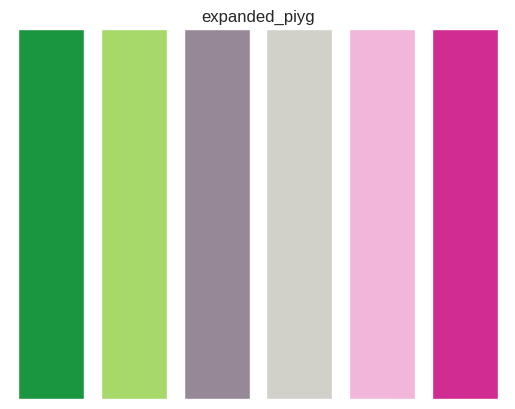

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [315]:
# set display params
sns.set(style = 'white')
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

In [321]:
subset_df

Empty DataFrame
Columns: [index, Time (hours), x, y, x scaled, y scaled, Infection status, Initial infection status, Final infection status, Area, Mtb Area, Eccentricity, MSD, Strain, Compound, Concentration, Technical replicate, Cell ID, Acquisition ID, Unique ID]
Index: []

In [318]:
custom_order = ['RD1', 'CTRL', 'PZA', 'RIF', 'INH', 'BDQ']

In [22]:
# fig, axes = plt.subplots(nrows=3, figsize=(6,6))

# Plot the last boxenplot 
sns.boxenplot(    x="dt", 
    y="Strain",
    hue="Strain",
     k_depth=k_depth,# "proportion", "trustworthy", "full"
    palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
    data=dt_df.drop_duplicates(subset=['Unique ID'], keep='first'), 
    scale='linear',
    width = 0.9,
    linewidth = linewidth,
    flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,
                    ),
    order= ['RD1', 'WT'],
    # ax=axes[2]  # Use the first subplot
)
linewidth = 0.5
# Create a figure with two vertically stacked subplots

plt.xlabel("Doubling time (hours)")
plt.ylabel("")  # Set the y-axis label
# axes[2].set_xlim(0)
sns.despine(offset=10)
# Adjust spacing between subplots
plt.tight_layout()

plt.gcf().suptitle(f'Distribution of intracellular Mtb doubling times (unverified)',# k_depth_vis={k_depth}', 
                   fontsize=15, fontweight=1000, 
                  y = 1.1)

plt.savefig(os.path.join(output_dir, 'dt_outliers_boxenplot_w_shared_axis.pdf'), bbox_inches = 'tight', dpi = 314)
# Show the combined plot
plt.show()



NameError: name 'k_depth' is not defined

In [336]:
filtered_df

Time (hours)   Mtb Area        dMtb Strain Compound Concentration  \
0                  0  46.797680  136.772588     WT     CTRL           EC0   
73                 0   1.743180  121.732073     WT      BDQ          EC50   
148                0   0.000000    0.000000     WT      INH          EC99   
222                0   0.000000  232.200521     WT     CTRL           EC0   
297                0  11.442413   -1.028029     WT      BDQ          EC99   
...              ...        ...         ...    ...      ...           ...   
296560             0   7.017417   -7.017417     WT      PZA          EC99   
296635             0   0.536363   24.918535     WT      INH          EC99   
296709             0   0.000000    0.000000     WT      INH          EC99   
296784             4   2.346589   32.829891     WT     CTRL           EC0   
296926             4   3.888632   -3.888632     WT     CTRL           EC0   

       Unique ID Acquisition ID  Cell ID  Mphi Area  ...  Infection Status  \
0          1.3.5         (3, 5)        1    29567.0  ...              True   
73         1.4.9         (4, 9)        1    21687.0  ...              True   
148        1.5.8         (5, 8)        1    48699.0  ...              True   
222        1.6.5         (6, 5)        1    43569.0  ...              True   
297        1.6.9         (6, 9)        1    67519.0  ...              True   
...          ...            ...      ...        ...  ...               ...   
296560    99.5.6         (5, 6)       99    39753.0  ...              True   
296635    99.5.8         (5, 8)       99    13841.0  ...              True   
296709    99.6.8         (6, 8)       99    18719.0  ...              True   
296784   991.4.5         (4, 5)      991    68784.0  ...              True   
296926   996.4.5         (4, 5)      996    43829.0  ...              True   

        Initial Infection Status  Final Infection Status  dMtb/dt,T=15  \
0                           True                    True           NaN   
73                         False                    True           NaN   
148                        False                   False           NaN   
222                        False                    True           NaN   
297                         True                    True           NaN   
...                          ...                     ...           ...   
296560                      True                   False           NaN   
296635                      True                    True           NaN   
296709                     False                   False           NaN   
296784                      True                    True           NaN   
296926                      True                   False           NaN   

        Max. dMtb/dt,T=15         dt           K         N0         b  \
0                6.314185  35.572443  265.591737  15.549781   0.05123   
73              11.741882  14.558938   112.51362   0.117724  0.175428   
148              0.470808        NaN        None       None      None   
222             16.962483        NaN        None       None      None   
297              0.665984        NaN        None       None      None   
...                   ...        ...         ...        ...       ...   
296560           0.490176        NaN        None       None      None   
296635           6.224792  58.124391  170.334187    2.86467  0.054319   
296709           0.195177        NaN        None       None      None   
296784           1.531615        NaN        None       None      None   
296926           0.064066        NaN        None       None      None   

               m  
0        0.52539  
73      0.427547  
148         None  
222         None  
297         None  
...          ...  
296560      None  
296635  0.319648  
296709      None  
296784      None  
296926      None  

[3310 rows x 32 columns]

In [389]:
dt_df.keys()

Index(['Time (hours)', 'Mtb Area', 'dMtb', 'Strain', 'Compound',
       'Concentration', 'Unique ID', 'Acquisition ID', 'Cell ID', 'Mphi Area',
       'Mphi GFP', 'x', 'y', 'Eccentricity', 'MSD', 'Technical Replicate',
       'Strain/Compound', 'dMtb/dt', '%dMtb/dt', '%dMtb', 'Mean Mtb Intensity',
       'Thresholded Mean Mtb Intensity', 'Infection Status',
       'Initial Infection Status', 'Final Infection Status', 'dMtb/dt,T=15',
       'Max. dMtb/dt,T=15', 'dt', 'K', 'N0', 'b', 'm'],
      dtype='object')

In [390]:
help(pearsonr)

Help on function pearsonr in module scipy.stats._stats_py:

pearsonr(x, y, *, alternative='two-sided', method=None)
    Pearson correlation coefficient and p-value for testing non-correlation.
    
    The Pearson correlation coefficient [1]_ measures the linear relationship
    between two datasets. Like other correlation
    coefficients, this one varies between -1 and +1 with 0 implying no
    correlation. Correlations of -1 or +1 imply an exact linear relationship.
    Positive correlations imply that as x increases, so does y. Negative
    correlations imply that as x increases, y decreases.
    
    This function also performs a test of the null hypothesis that the
    distributions underlying the samples are uncorrelated and normally
    distributed. (See Kowalski [3]_
    for a discussion of the effects of non-normality of the input on the
    distribution of the correlation coefficient.)
    The p-value roughly indicates the probability of an uncorrelated system
    producing 

WT
RD1


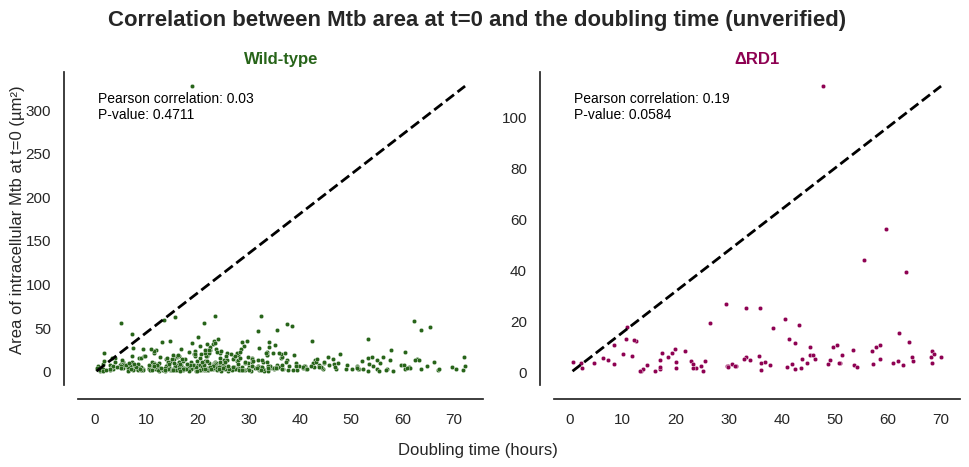

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Assuming subset_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain, colour_map) in enumerate(zip(['WT', 'RD1'], [custom_green_cmap, custom_pink_cmap])):
    print(strain)
    # if strain == 'WT':
        
    filtered_df = dt_df[(dt_df['Strain'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    filtered_df = filtered_df[filtered_df['Mtb Area'] <= 500]
    filtered_df = filtered_df.dropna(subset=['dt'])
    
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['dt']

    exluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0< n]#<600]
    N0 = [i[0] for i in exluding_outliers]
    max_gr = [i[1] for i in exluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i], color=colour_map[0], s = 10, label='')#'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i].set_xlabel("")  # Clear the individual x-labels
    axes[i].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}"
                     , xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i].set_title('ΔRD1' if strain != 'WT' else 'Wild-type', color=colour_map[0], fontweight = 'bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Doubling time (hours)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm\u00b2)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the doubling time (unverified)', fontweight = 'bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(base_dir, 'manuscript/crop_N0_dt_control.pdf'), bbox_inches = 'tight', dpi = 314)
# Display the plot
plt.show()


In [ ]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=dt_df, 
            scale = 'linear', order = custom_order
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

In [ ]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df, 
            scale = 'linear', order = custom_order
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

In [351]:
len(PS_sc_df), len(ND_sc_df)

(291526, 227591)

In [352]:
sns.boxenplot(    x="dt", 
    y="Strain",
    hue="Strain",
     k_depth=k_depth,# "proportion", "trustworthy", "full"
    palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
    data=dt_df.drop_duplicates(subset=['Unique ID'], keep='first'), 
    scale='linear',
    width = 0.9,
    linewidth = linewidth,
    flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,
                    ),
    order= ['RD1', 'WT'],
    # ax=axes[2]  # Use the first subplot
)
linewidth = 0.5
# Create a figure with two ver

Index(['Time (hours)', 'Mtb Area', 'dMtb', 'Strain', 'Compound',
       'Concentration', 'Unique ID', 'Acquisition ID', 'Cell ID', 'Mphi Area',
       'Mphi GFP', 'x', 'y', 'Eccentricity', 'MSD', 'Technical Replicate',
       'Strain/Compound', 'dMtb/dt', '%dMtb/dt', '%dMtb', 'Mean Mtb Intensity',
       'Thresholded Mean Mtb Intensity', 'Infection Status',
       'Initial Infection Status', 'Final Infection Status', 'dMtb/dt,T=15',
       'Max. dMtb/dt,T=15', 'Mtb area new (um2)'],
      dtype='object')

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/pytho

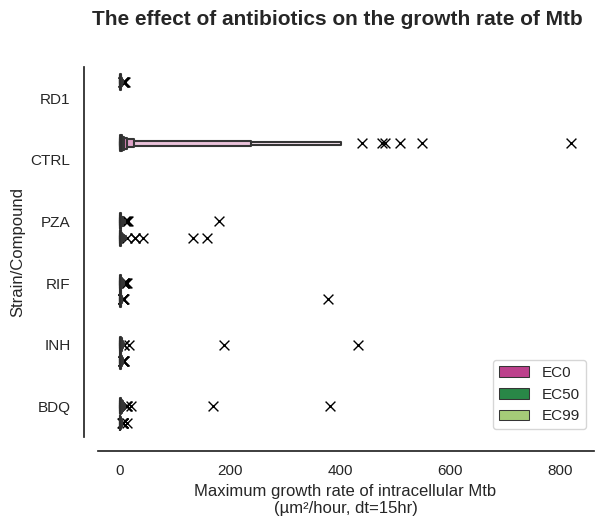

In [356]:
g = sns.boxenplot(x="Max. dMtb/dt,T=15", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=df.drop_duplicates(subset=['Unique ID'], keep='first'),
            scale = 'linear', order = custom_order, 
                  flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,)
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/categorical.py:1953: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xs_outliers, ys_outliers,
/home/dayn/miniconda3/envs/egg/lib/pytho

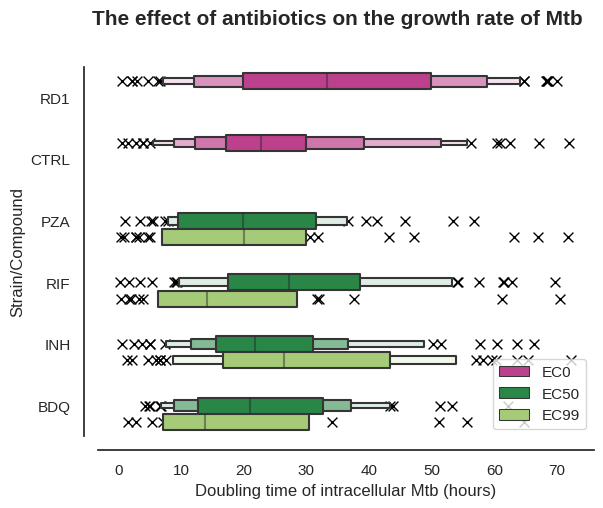

In [358]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=dt_df.drop_duplicates(subset=['Unique ID'], keep='first'),
            scale = 'linear', order = custom_order, 
                  flier_kws = dict(marker='x', 
                     color='black',#green_colors[0],
                     edgecolors='black',#expanded_piyg[2],
                     linewidths=linewidth*2,
                     s=50,)
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
# plt.savefig(os.path.join(output_dir, 'ATB_effect_max_growth_rate.png'), bbox_inches = 'tight', dpi = 314)

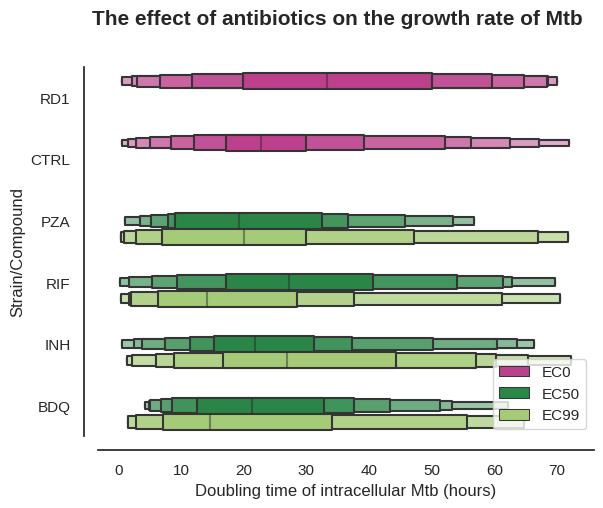

In [360]:
g = sns.boxenplot(x="dt", y="Strain/Compound",
            hue="Concentration", 
            palette=[expanded_piyg[-1], expanded_piyg[0], expanded_piyg[1]],
            data=dt_df, 
            scale = 'linear', order = custom_order
              )  
sns.despine(offset = 10)
# g.set_xscale('log')
plt.xlabel("Doubling time of intracellular Mtb (hours)")
plt.gcf().suptitle('The effect of antibiotics on the growth rate of Mtb', 
                   fontsize=15, fontweight='bold', 
                  y = 1.0)
sns.despine(offset=10)
plt.legend(loc = 'lower right')
plt.savefig(os.path.join(output_dir, 'ATB_effect_dt_unverified.pdf'), bbox_inches = 'tight', dpi = 314)

In [366]:
dt_df['Strain/Compound'].unique()

array(['CTRL', 'BDQ', 'INH', 'PZA', 'RIF', 'RD1'], dtype=object)

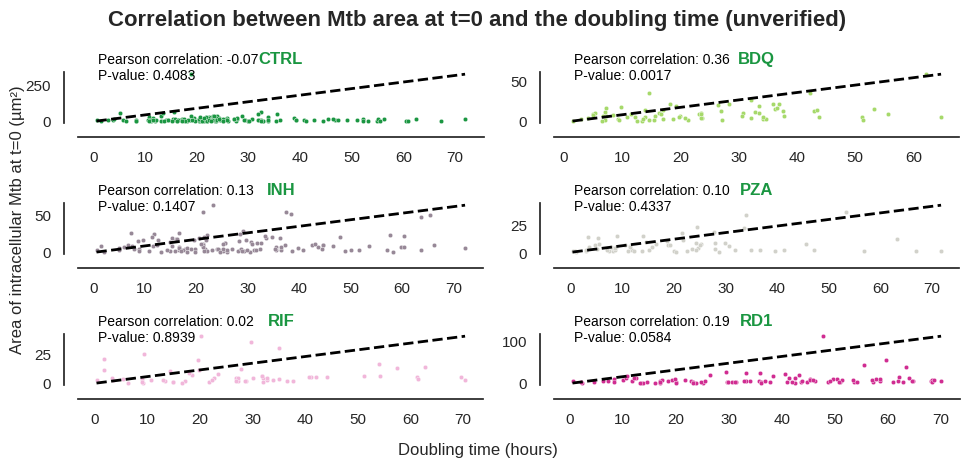

In [383]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assuming dt_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps
colour_map = expanded_piyg
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain) in enumerate(dt_df['Strain/Compound'].unique()):
    filtered_df = dt_df[(dt_df['Strain/Compound'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    filtered_df = filtered_df[filtered_df['Mtb Area'] <= 500]
    filtered_df = filtered_df.dropna(subset=['dt'])
    
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['dt']

    excluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0 < n]  # < 600]
    N0 = [i[0] for i in excluding_outliers]
    max_gr = [i[1] for i in excluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i//2, i%2], color=colour_map[i], s=10, label='')  # 'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i//2, i%2].set_xlabel("")  # Clear the individual x-labels
    axes[i//2, i%2].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i//2, i%2].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i//2, i%2].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}",
                             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i//2, i%2].set_title(strain, color=colour_map[0], fontweight='bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Doubling time (hours)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm²)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the doubling time (unverified)', fontweight='bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(output_dir, 'scatter_plot_N0_dt.pdf'), bbox_inches='tight', dpi=314)
# Display the plot
plt.show()


In [380]:
len(dt_df[dt_df['dt']>0]['Unique ID'].unique())

672

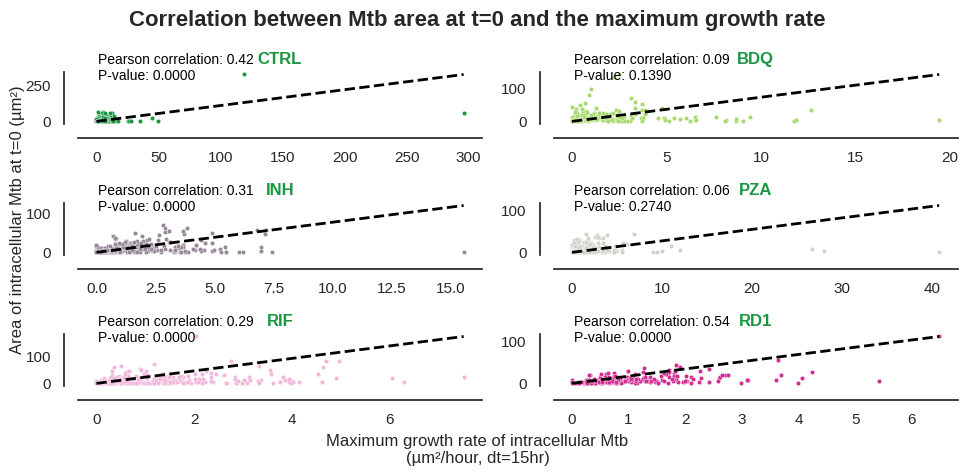

In [376]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Assuming dt_df is your DataFrame
# Assuming custom_green_cmap and custom_pink_cmap are defined color maps
colour_map = expanded_piyg
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=False)  # Add sharey=True to share the y-axis

for i, (strain) in enumerate(dt_df['Strain/Compound'].unique()):
    filtered_df = df[(df['Strain/Compound'] == strain)].drop_duplicates(subset=['Unique ID'], keep='first')
    filtered_df = filtered_df[filtered_df['Mtb Area'] <= 500]
    filtered_df = filtered_df.dropna(subset=['Max. dMtb/dt,T=15'])
    
    N0 = filtered_df['Mtb Area']
    max_gr = filtered_df['Max. dMtb/dt,T=15']

    excluding_outliers = [(n, g) for n, g in zip(N0, max_gr) if 0 < n]  # < 600]
    N0 = [i[0] for i in excluding_outliers]
    max_gr = [i[1] for i in excluding_outliers]
    
    sns.scatterplot(x=max_gr, y=N0, ax=axes[i//2, i%2], color=colour_map[i], s=10, label='')  # 'ΔRD1' if strain != 'WT' else 'Wild-type')
    sns.despine(offset=10)
    axes[i//2, i%2].set_xlabel("")  # Clear the individual x-labels
    axes[i//2, i%2].set_ylabel("")  # Clear the individual y-labels
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_gr, N0)
    
    # Plot the correlation line
    axes[i//2, i%2].plot([min(max_gr), max(max_gr)], [min(N0), max(N0)], color='black', linestyle='--', linewidth=2)
    
    # Annotate the correlation coefficient and p-value
    axes[i//2, i%2].annotate(f"Pearson correlation: {corr_coef:.2f}\nP-value: {p_value:.4f}",
                             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')
    
    # Add subplot titles
    axes[i//2, i%2].set_title(strain, color=colour_map[0], fontweight='bold')

# Add a common xlabel and ylabel for the figure
fig.text(0.5, 0.04, "Maximum growth rate of intracellular Mtb\n(µm\u00b2/hour, dt=15hr)", ha='center', va='center')
fig.text(0.04, 0.5, "Area of intracellular Mtb at t=0 (µm²)", ha='center', va='center', rotation='vertical')

# Add a super title
fig.suptitle('Correlation between Mtb area at t=0 and the maximum growth rate', fontweight='bold', fontsize=16, y=0.92)

# Optionally, adjust the layout
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

plt.savefig(os.path.join(output_dir, 'scatter_plot_N0_maxmdmtb.pdf'), bbox_inches='tight', dpi=314)
# Display the plot
plt.show()


<Axes: xlabel='Mtb Area', ylabel='Count'>

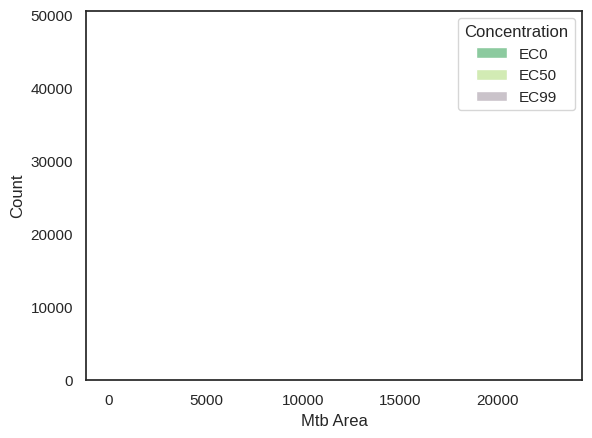

In [386]:
sns.histplot(data = df, x = 'Mtb Area', hue = 'Strain/Compound')

<Axes: xlabel='Mtb Area', ylabel='Count'>

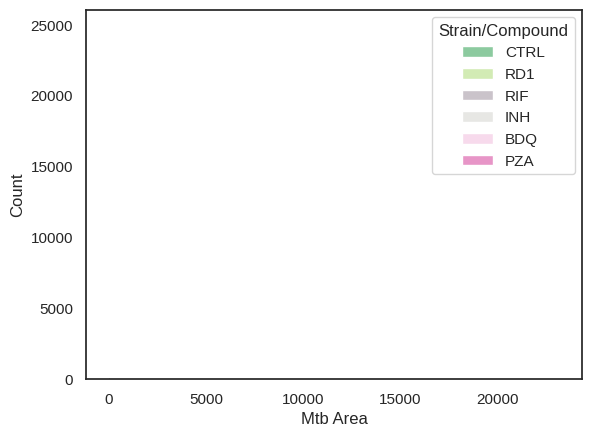

In [387]:
sns.histplot(data = df, x = 'Mtb Area', hue = 'Strain/Compound')

# Arx

### Comparing Atbs

#### Add repeat number to assay layout

In [386]:
n = 0
labels = []
assay_layout['Technical repeat'] = 0

for (row, column), info in assay_layout.iterrows():
    strain = info['Strain']
    comp = info['Compound']
    conc = info['Concentration']
    ec_conc = info['ConcentrationEC']
    label = f'{strain},{comp},{ec_conc},{conc}'     
    if label not in labels:
        n =1
        assay_layout.loc[(row, column), 'Technical repeat'] = n
        labels.append(label)
    else:
        n = labels.count(label)+1
        assay_layout.loc[(row, column), 'Technical repeat'] = n
        labels.append(label)

In [390]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

### mapping colours to previous

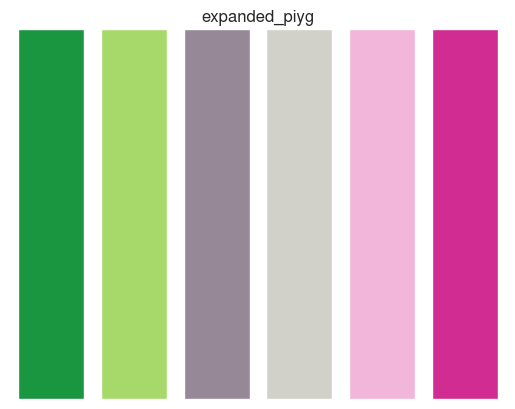

[(0, '#1a9641'),
 (1, '#a6d96a'),
 (2, '#978897'),
 (3, '#d1d1ca'),
 (4, '#f1b6da'),
 (5, '#d02c91')]

In [413]:
### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg')
[(n, i) for n, i in enumerate(colours.expanded_piyg)]

In [419]:
colour_map_dict = {'RD1':colours.expanded_piyg[0], 
                   'WT': colours.expanded_piyg[1], 
                   'PZA': colours.expanded_piyg[2], 
                   'RIF': colours.expanded_piyg[3], 
                   'INH': colours.expanded_piyg[4], 
                   'BDQ': colours.expanded_piyg[5], 
                   'UNI': '#000000'}

In [418]:
strain

'UNI'

In [417]:
strain in colour_map_dict.keys()

False

### Plot different atb conditions per repeat

/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


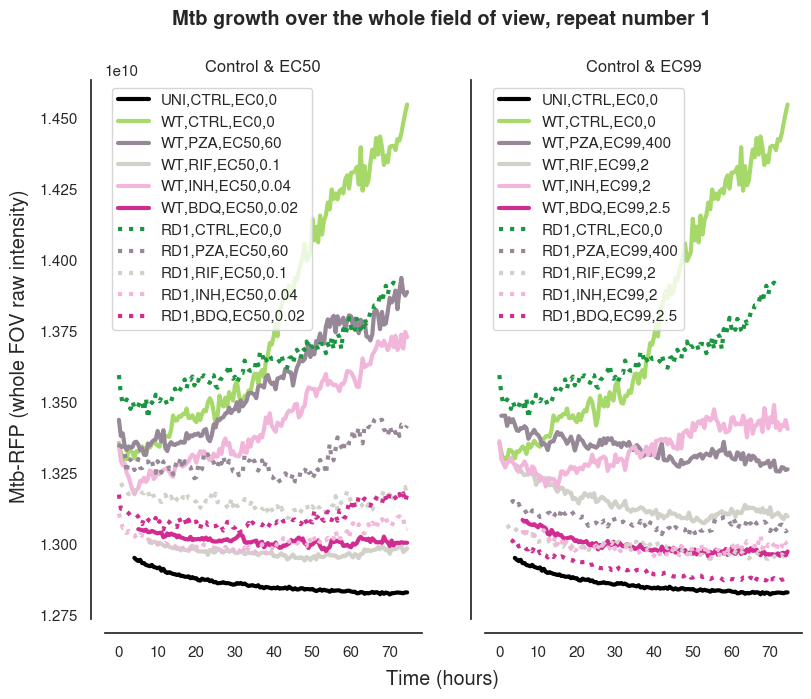

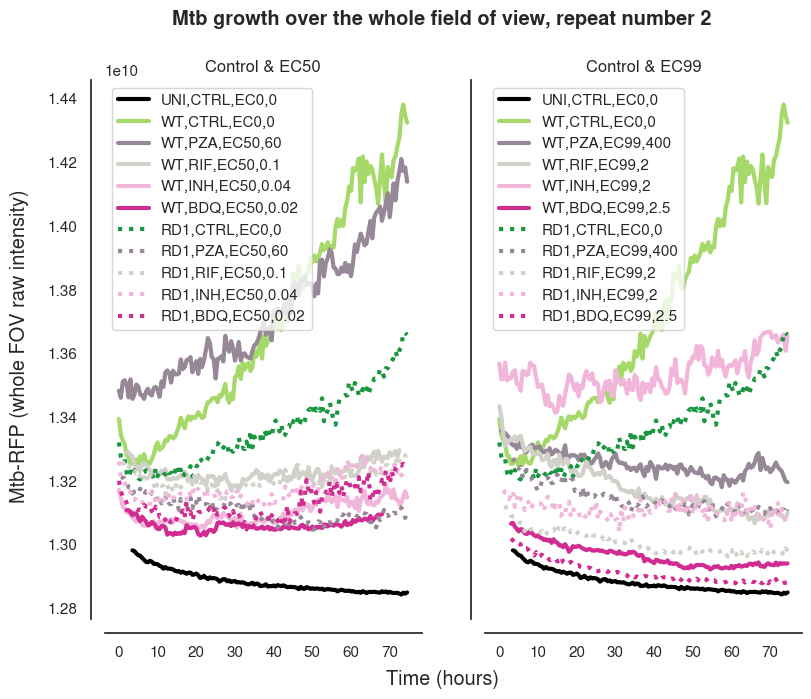

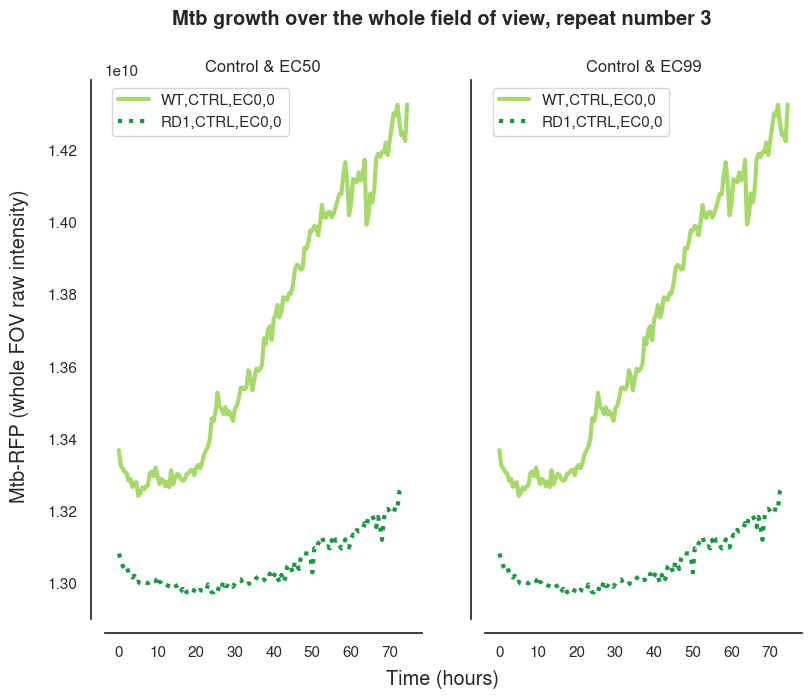

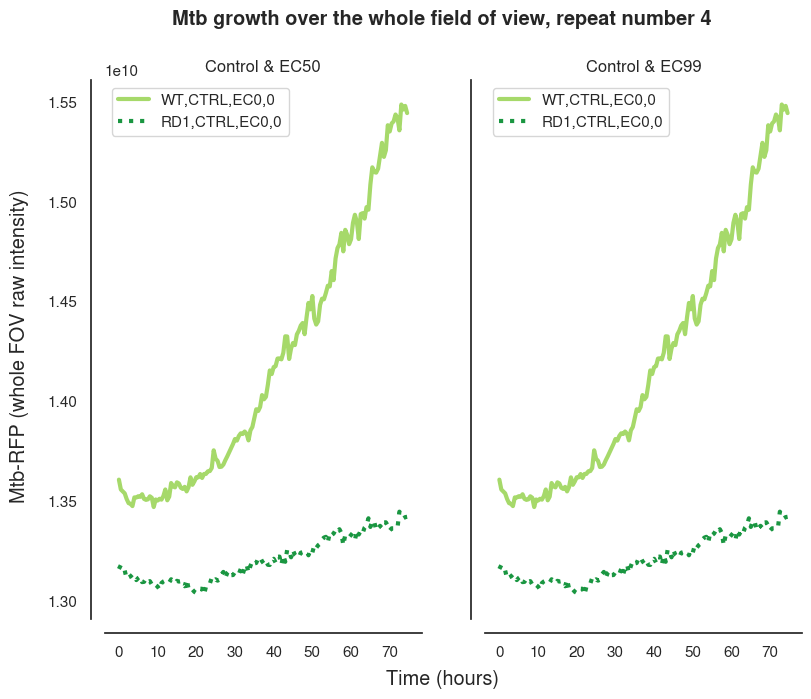

In [422]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wRD1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


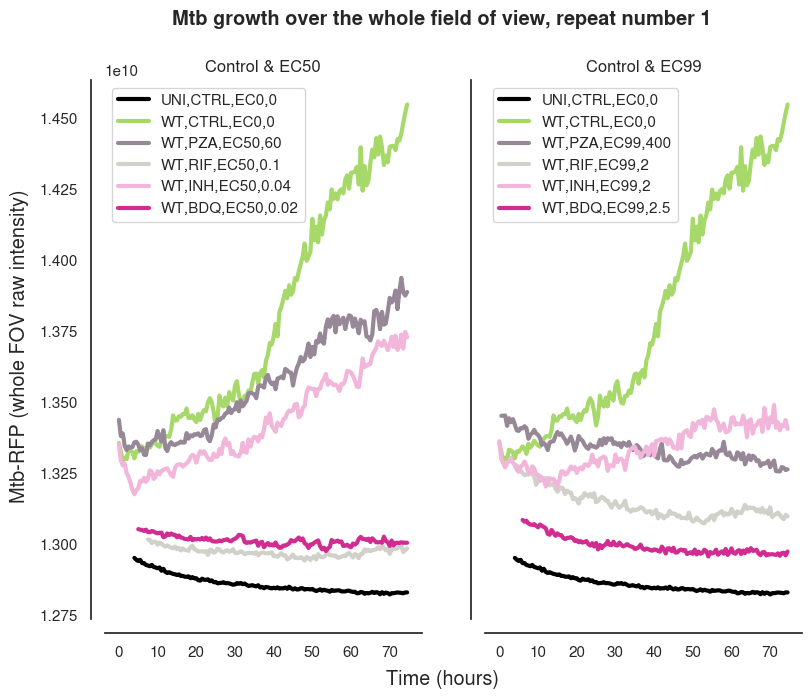

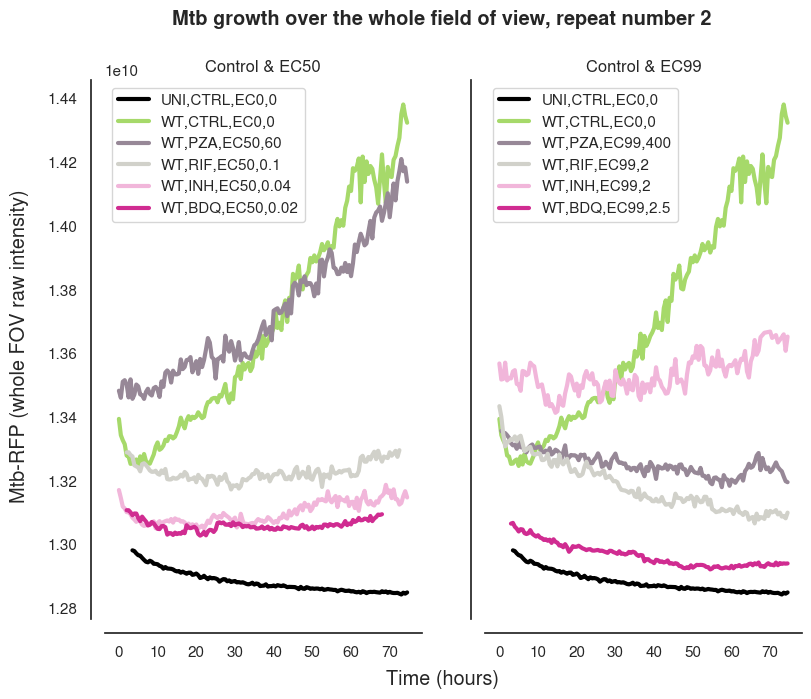

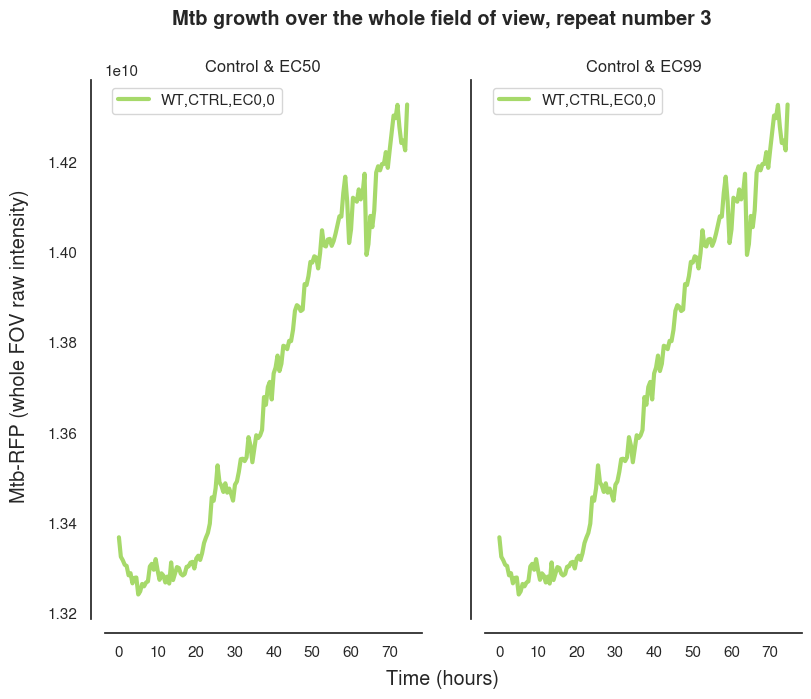

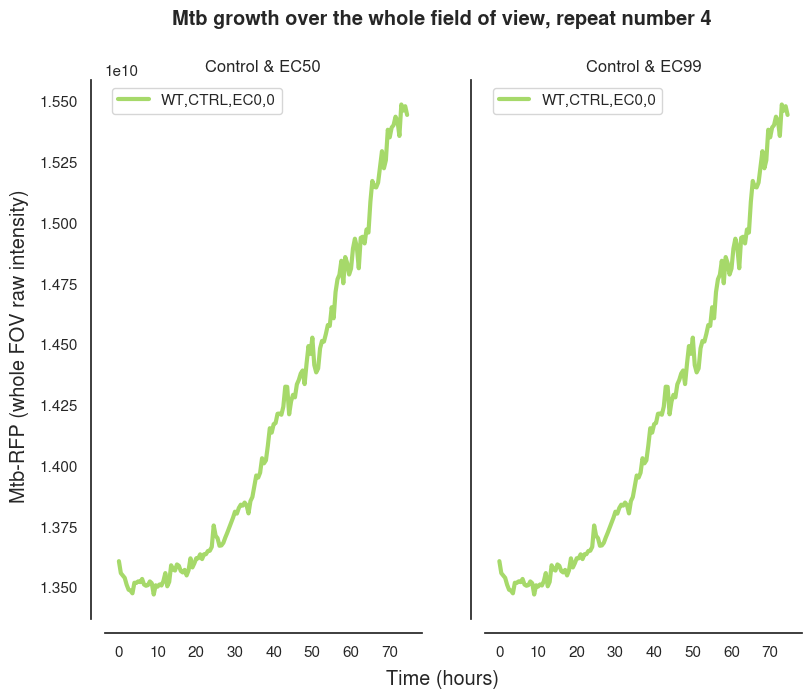

In [423]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


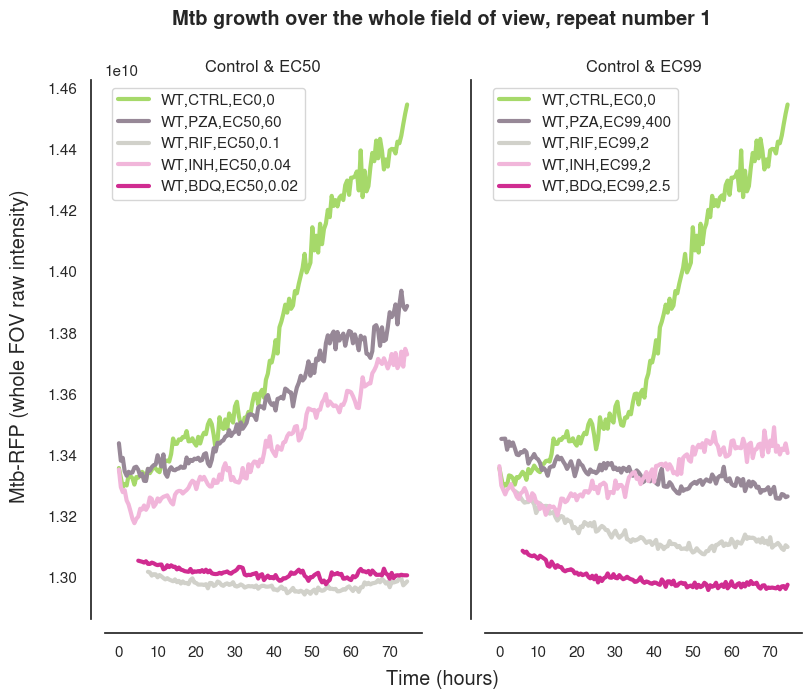

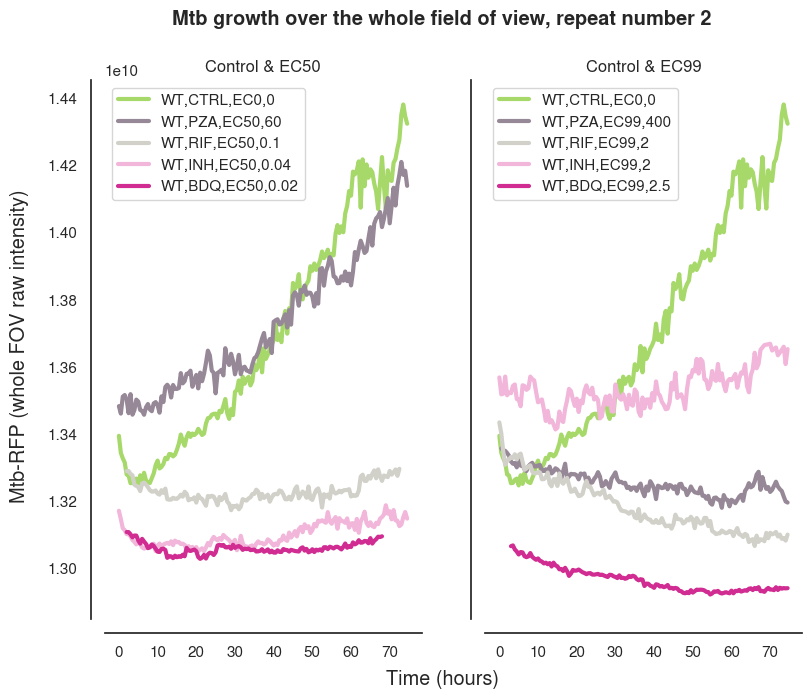

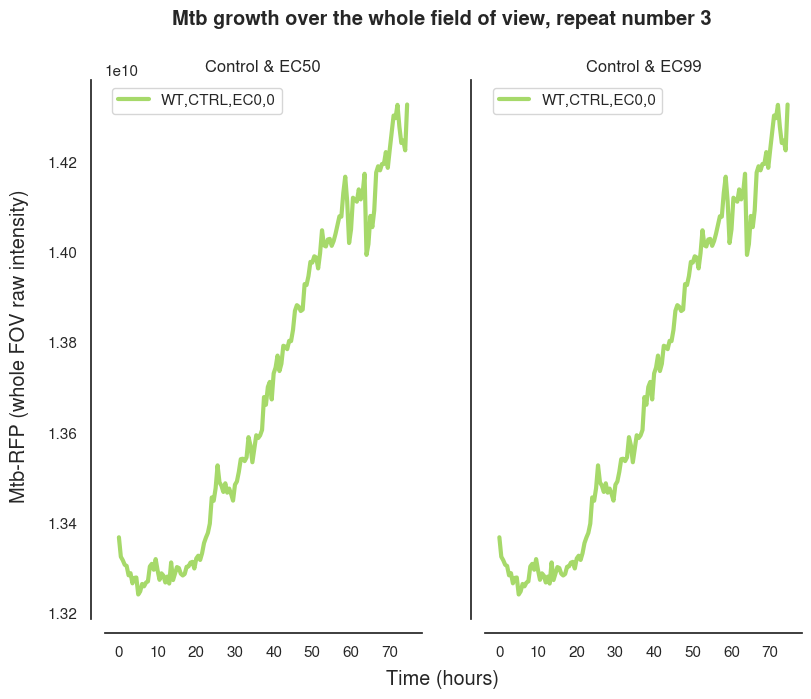

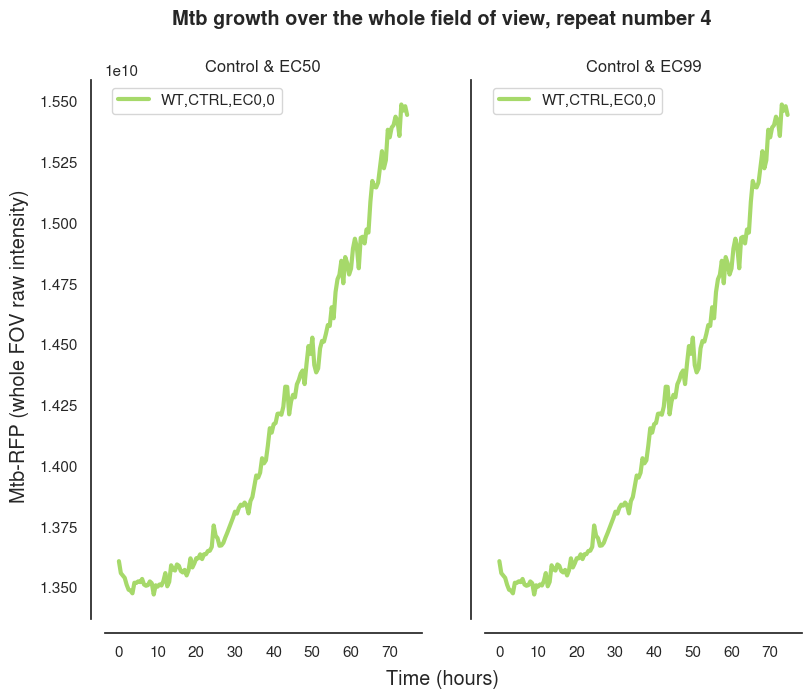

In [424]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_word1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


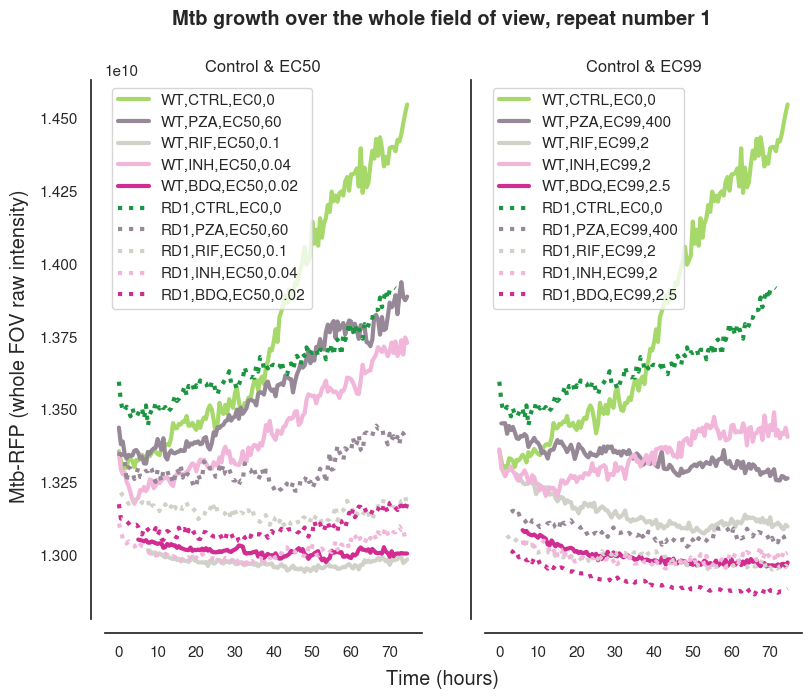

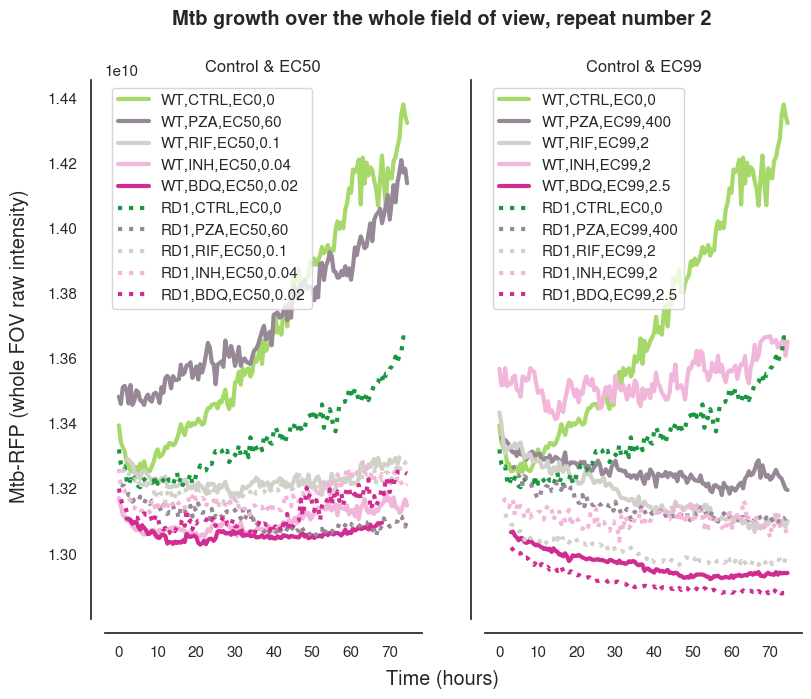

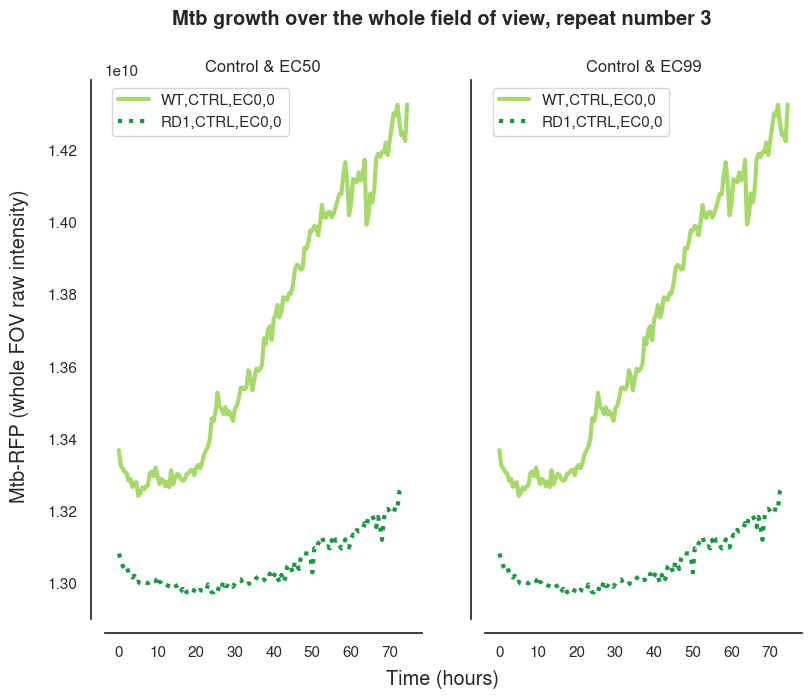

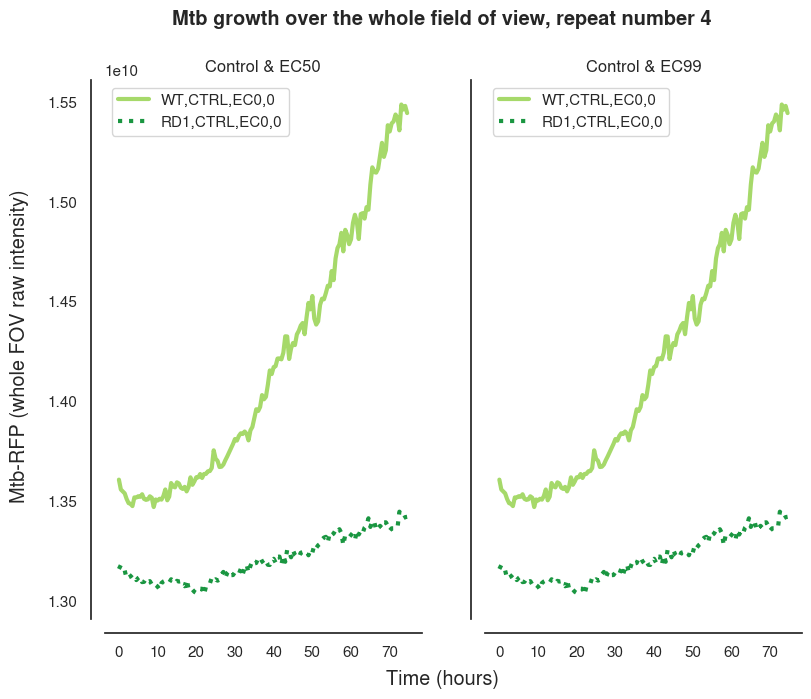

In [425]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



### Plotting repeats overlaid

In [450]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [449]:
assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates()

Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
4   5          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
6   5         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99

In [451]:
for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    print(info)


Strain              UNI
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 1), dtype: object
Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 3), dtype: object
Strain               WT
Compound            PZA
Concentration        60
ConcentrationEC    EC50
Name: (3, 5), dtype: object
Strain               WT
Compound            RIF
Concentration       0.1
ConcentrationEC    EC50
Name: (3, 7), dtype: object
Strain               WT
Compound            INH
Concentration      0.04
ConcentrationEC    EC50
Name: (3, 9), dtype: object
Strain               WT
Compound            BDQ
Concentration      0.02
ConcentrationEC    EC50
Name: (3, 11), dtype: object
Strain               WT
Compound            PZA
Concentration       400
ConcentrationEC    EC99
Name: (4, 5), dtype: object
Strain               WT
Compound            RIF
Concentration         2
ConcentrationEC    EC99
Name: (4, 7), dtype: object
Strain 

In [453]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [473]:
cleaned_series

0             1             2             3    \
Row Column                                                           
6   11      1.310772e+10  1.308648e+10  1.307119e+10  1.305876e+10   
    12      1.311994e+10  1.309136e+10  1.305267e+10  1.304545e+10   

                     4             5             6             7    \
Row Column                                                           
6   11      1.304037e+10  1.304033e+10  1.301729e+10  1.301309e+10   
    12      1.304272e+10  1.302610e+10  1.301955e+10  1.301408e+10   

                     8             9    ...           140           141  \
Row Column                              ...                               
6   11      1.299978e+10  1.300731e+10  ...  1.287938e+10  1.287871e+10   
    12      1.300614e+10  1.300051e+10  ...  1.288578e+10  1.287866e+10   

                     142           143           144           145  \
Row Column                                                           
6   11      1.288302e+10  1.287753e+10  1.287248e+10  1.287729e+10   
    12      1.288287e+10  1.289255e+10  1.288116e+10  1.288207e+10   

                     146           147           148           149  
Row Column                                                          
6   11      1.287703e+10  1.287929e+10  1.288263e+10  1.288682e+10  
    12      1.287799e+10  1.288075e+10  1.288131e+10  1.288176e+10  

[2 rows x 150 columns]

In [470]:
assay_layout['Technical repeat'].unique()

array([1, 2, 3, 4])

In [484]:
concat_series

8      1.295410e+10
9      1.294740e+10
10     1.294297e+10
11     1.294719e+10
12     1.293553e+10
           ...     
145    1.284703e+10
146    1.284426e+10
147    1.284991e+10
148    1.284697e+10
149    1.285080e+10
Length: 285, dtype: float64

/tmp/ipykernel_1217616/2323974640.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


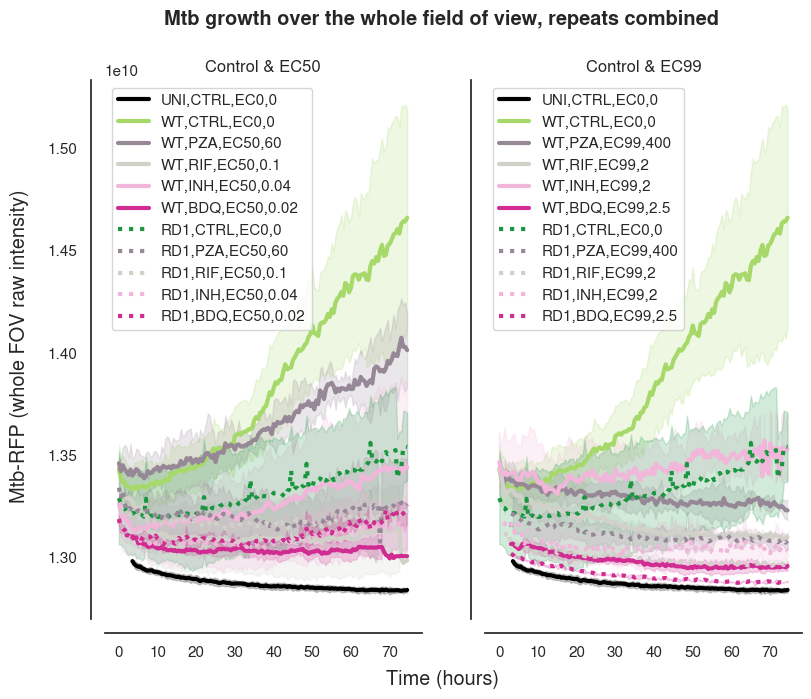

In [498]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3755018027.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


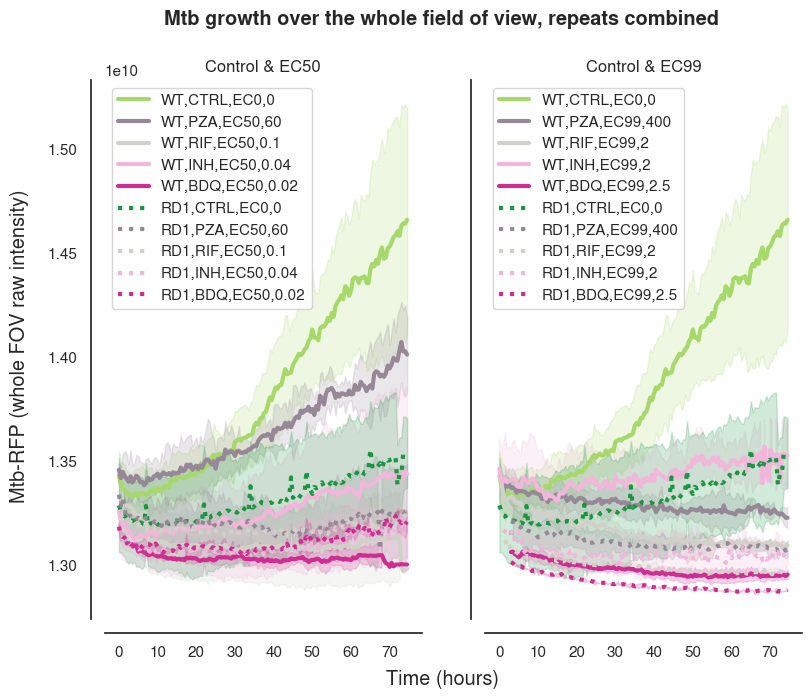

In [499]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3533890359.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


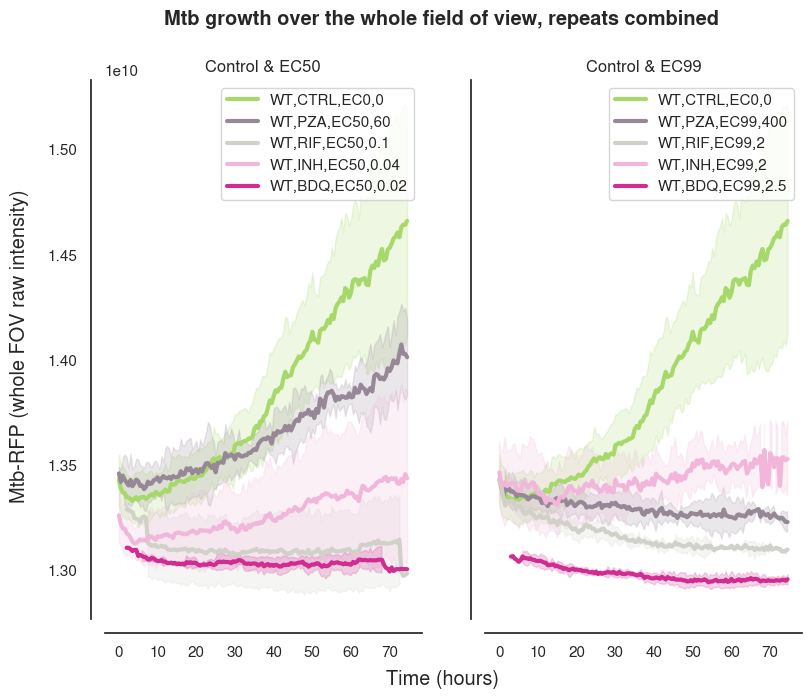

In [500]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI', 'RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/235941939.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


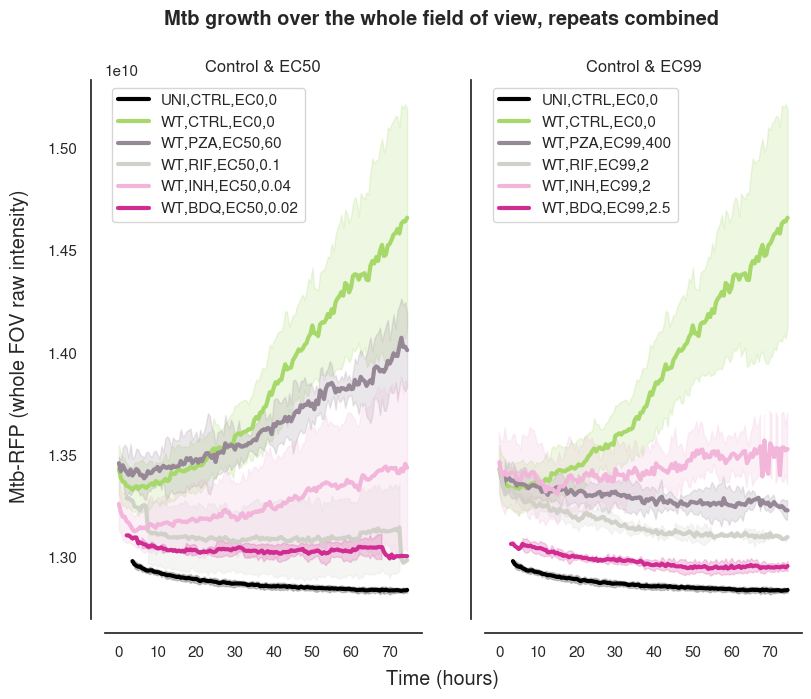

In [501]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()

